# Coverage depth analysis

Coverage depth histogram

In [26]:
from common import *
import numpy as np 
import pandas as pd

drop_cols = ["percentMeth_C", "percentMeth_5mC", "percentMeth_5hmC", "strand"]

prom_raw = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "Nanopore")
oxbs_raw = readBismarkZeroCov("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "oxBS-seq")
tab_raw = readBismarkZeroCov("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "TAB-seq")

histogram_df = pd.concat([prom_raw, oxbs_raw, tab_raw])

In [43]:
from common import *

prom_pr = Modkit2Pr("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, True)
oxbs_pr = Bismark2Pr("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False, True)
tab_pr = Bismark2Pr("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False, True)

Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done


In [45]:
prom_pr.as_df().query("readCount >= 10")["N_hmC"].sum()/prom_pr.as_df().query("readCount >= 10")["readCount"].sum()

0.08166272631272153

In [47]:
tab_pr.as_df().query("readCount >= 10")["N_mod"].sum()/tab_pr.as_df().query("readCount >= 10")["readCount"].sum()

0.1023957340956094

In [18]:
# exclusive sets
prom_excl = len(prom_pr.intersect(oxbs_pr, invert=True).intersect(tab_pr, invert=True))
tab_excl = len(tab_pr.intersect(oxbs_pr, invert=True).intersect(prom_pr, invert=True))
oxbs_excl = len(oxbs_pr.intersect(tab_pr, invert=True).intersect(prom_pr, invert=True))

# three-way intersect 
prom_tab_oxbs = prom_pr.join(tab_pr, suffix="_TAB").join(oxbs_pr, suffix="_oxBS")

# two-way intersects
prom_tab = len(prom_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
prom_oxbs = len(prom_pr.intersect(oxbs_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
tab_oxbs = len(oxbs_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))

total = sum([prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)])


In [54]:
intersect = len(prom_tab_oxbs)
bar_df = pd.DataFrame({"method" : ["Nanopore", "TAB-seq", "oxBS-seq"], 
                       "present" : [prom_excl/total, tab_excl/total, oxbs_excl/total],
                       "missing" : [1 - (sum([prom_excl, prom_oxbs, prom_tab, intersect])/total), 
                                     1 - (sum([tab_excl, tab_oxbs, prom_tab, intersect])/total), 
                                     1 - (sum([oxbs_excl, tab_oxbs, prom_oxbs, intersect])/total)]})



Feature intersection

In [100]:
import FeatureReferences
import pyranges as pr 

def annotateFeatures(pyrange): 
    annotated_df = pyrange.join(feature_ref, strandedness=False, slack=0, apply_strand_suffix=False).as_df()
    annotated_df = annotated_df.replace(["3UTR", "5UTR", "TSS"], ["Exon", "Exon", "Promoter"])
    intergenic = pyrange.intersect(feature_ref, invert=True).as_df()
    intergenic = intergenic.assign(feature_type = "Intergenic")
    return pd.concat([annotated_df, intergenic])

feature_ref = FeatureReferences.featureRefPyRange("./feature_references/genic/")

In [101]:
annotated_prom = annotateFeatures(prom_pr).assign(method="Nanopore")
annotated_tab = annotateFeatures(tab_pr).assign(method="TAB-seq")
annotated_oxbs = annotateFeatures(oxbs_pr).assign(method="oxBS-seq")

In [105]:
drop_cols = ["percentMeth_5hmC", "percentMeth_5mC", "__ix__", "N_hmC", "N_mC", "N_unmod", "N_mod", "N_C", "Start_b", "End_b", "Strand_b"]
annotated_prom, annotated_tab, annotated_oxbs = map(lambda df: df.drop(columns=drop_cols, errors="ignore"), [annotated_prom, annotated_tab, annotated_oxbs])
annotated_all = pd.concat([annotated_prom, annotated_tab, annotated_oxbs])
annotated_all["feature_type"] = pd.Categorical(annotated_all["feature_type"], ordered=True, categories=["Intergenic", "Promoter", "Intron", "Exon"])

## Figure

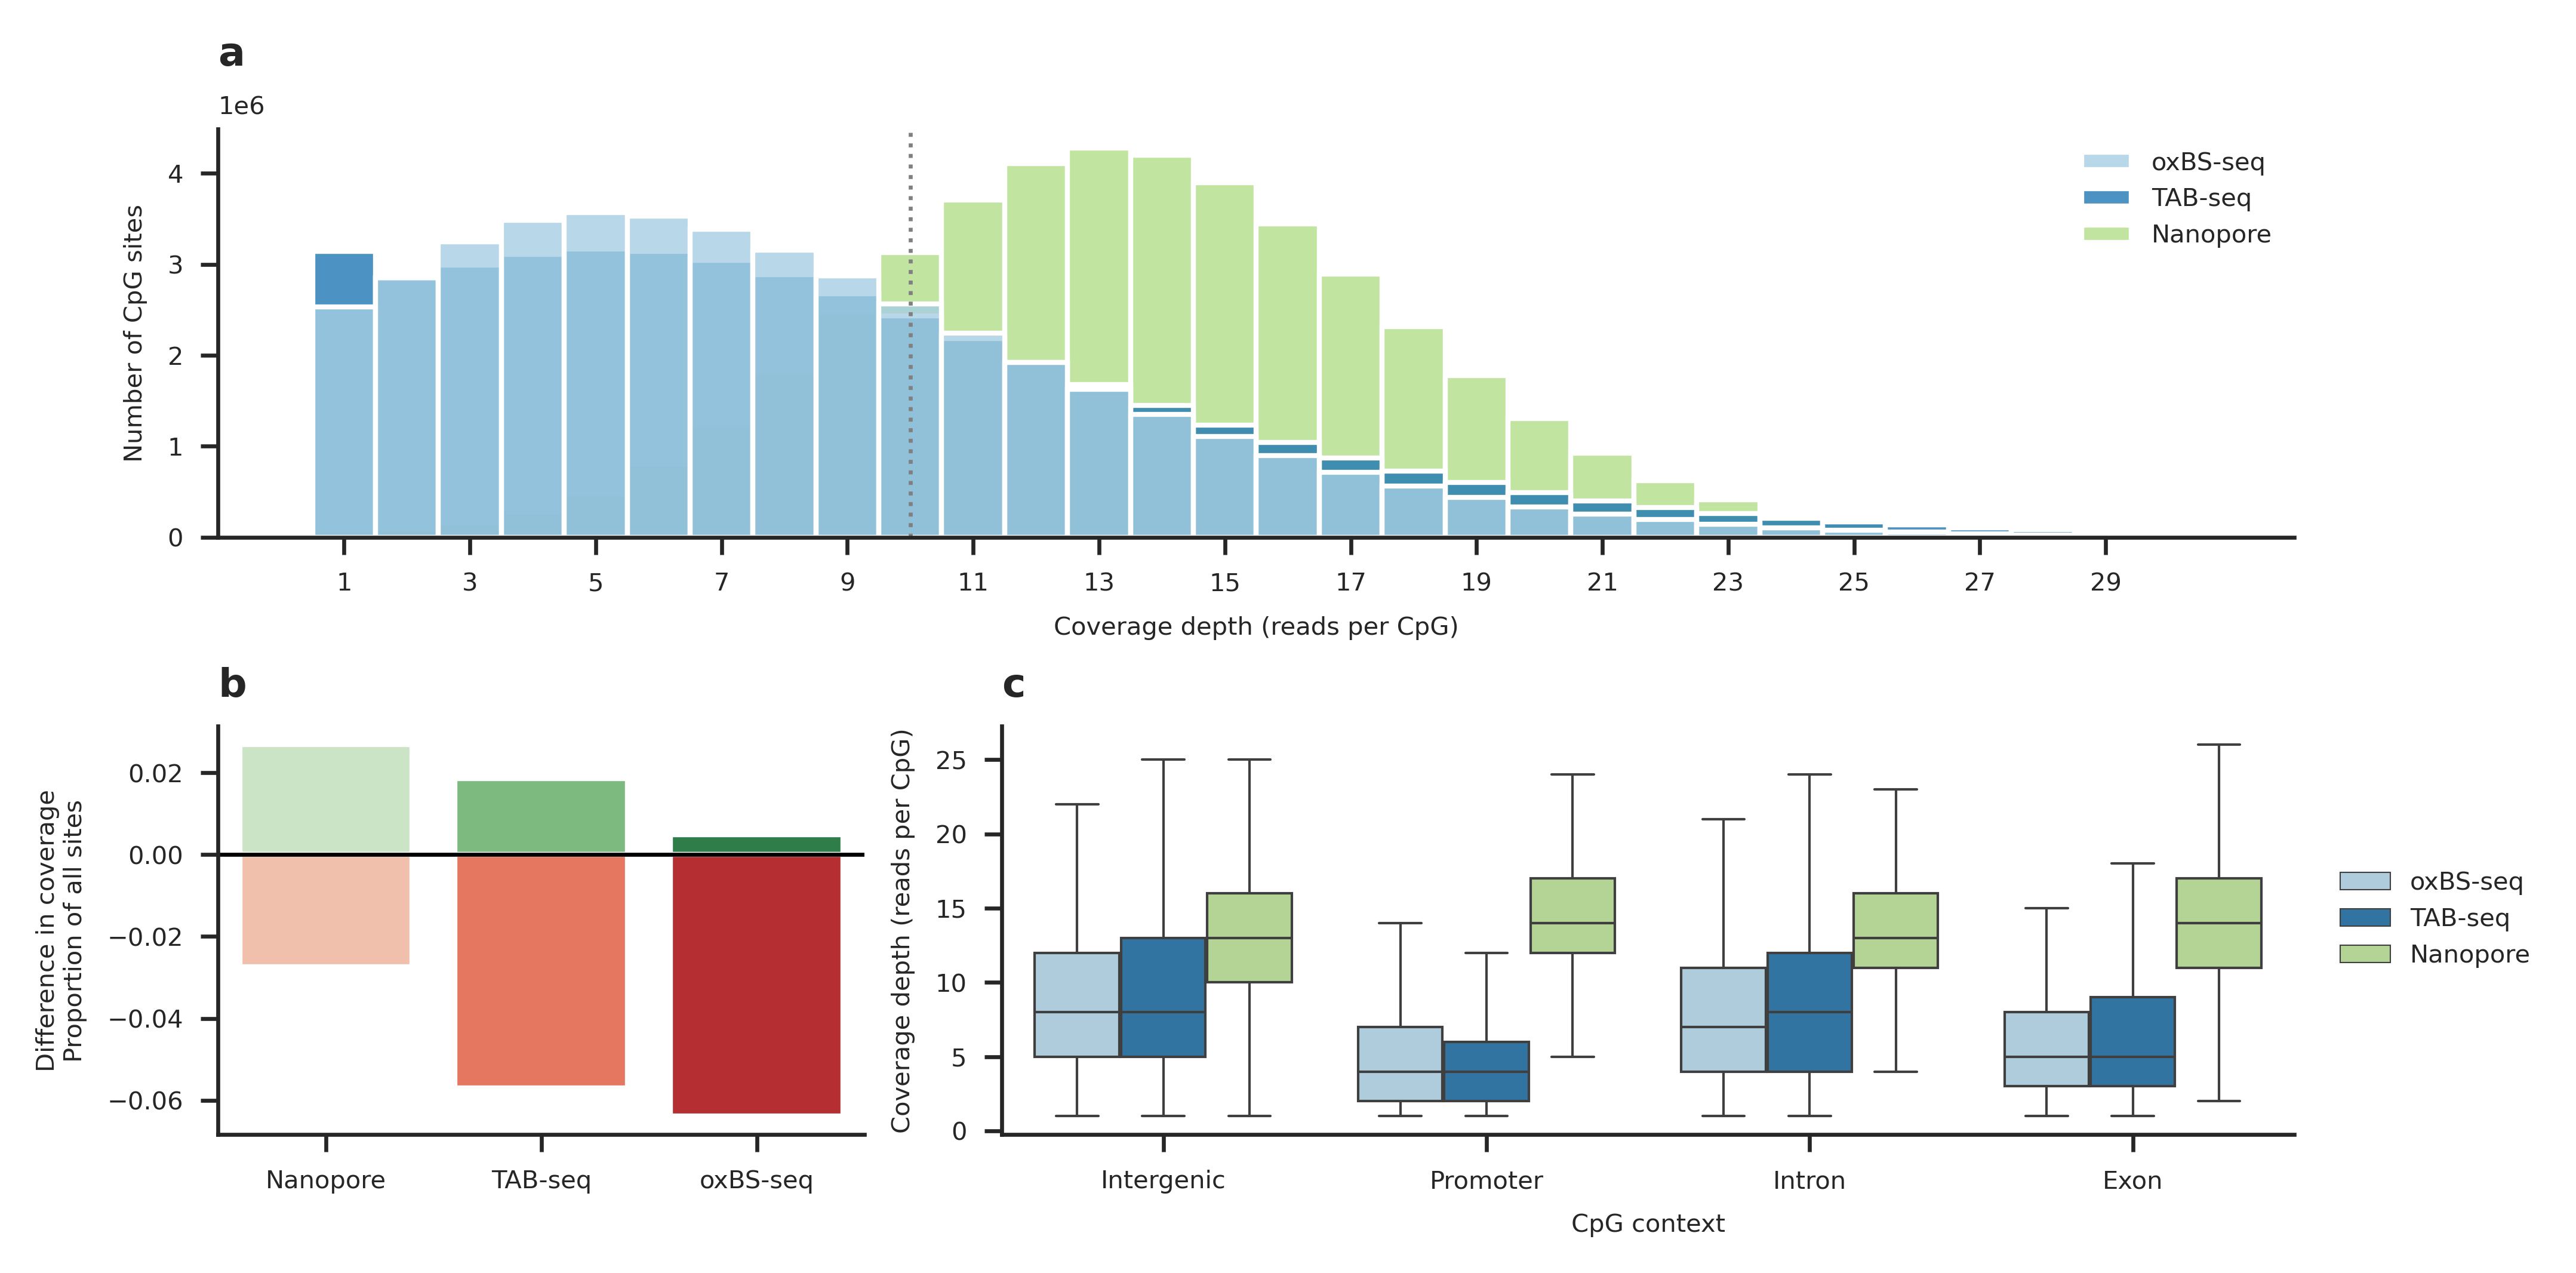

In [109]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import string

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(180/25.4, 89/25.4), dpi=600)
gs = GridSpec(2, 2, fig, width_ratios=(.5, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Panel 1 #
sns.histplot(annotated_all, x="readCount", 
             stat="count", discrete=True, binwidth=1, binrange=(1, 30),
             hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
             legend=True, alpha=0.8, ax=ax1)

ax1.axvline(10, ls=":", c="grey", lw=0.8, label="Minimum")
ax1.set_ylabel("Number of CpG sites")
ax1.set_xlabel("Coverage depth (reads per CpG)")

ax1.set_xticks(range(1, 31, 2))
sns.move_legend(ax1, "upper right", title=None, frameon=False)

# Panel 2 # 
sns.barplot(x=bar_df["method"], y=bar_df["present"], hue=bar_df["method"], palette="Greens", dodge=False, ax=ax2)
sns.barplot(x=bar_df["method"], y=-bar_df["missing"], hue=bar_df["method"], palette="Reds", dodge=False, ax=ax2)

ax2.legend([], [], frameon=False)
ax2.set_ylabel("Difference in coverage\nProportion of all sites")
ax2.set_xlabel(None)
ax2.axhline(0, c="k", lw=.8)

# Panel 3 #
sns.boxplot(annotated_all, x="feature_type", y="readCount", 
            hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
            dodge=True, linewidth=0.5, showfliers=False, 
            ax=ax3)

ax3.set_xlabel("CpG context")
ax3.set_ylabel("Coverage depth (reads per CpG)")

ax3.legend(title=None, frameon=False, bbox_to_anchor=(1.2, .7))

# Panel 3 # 

sns.despine(fig)

for ax, letter in zip([ax1, ax2, ax3], string.ascii_lowercase[:3]):
    ax.set_title(letter, loc="left", fontsize=8, fontweight="bold")

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/coverage_and_depth.png", dpi=600)


# CpG level comparison

In [1]:
import common 
import pandas as pd

prom_oxbs_data = pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv")
prom_tab_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

## RMSE

In [2]:
import pyranges as pr
import FeatureReferences
from sklearn import metrics

feature_ref = FeatureReferences.featureRefPyRange("./feature_references/genic/")

def annotateDataframe(dataframe):
    feature_annotations = pr.PyRanges(dataframe).join(feature_ref, strandedness=False, slack=0, apply_strand_suffix=False).as_df()
    feature_annotations = feature_annotations.drop(columns=["Start_b", "End_b", "Strand_b"])
    feature_annotations = feature_annotations.replace(["3UTR", "5UTR"], ["Exon", "Exon"])

    intergenic = pr.PyRanges(dataframe).intersect(feature_ref, invert=True).as_df()
    intergenic = intergenic.assign(feature_type = "Intergenic")

    return pd.concat([feature_annotations, intergenic])

annotated_prom_tab = annotateDataframe(prom_tab_data)
annotated_prom_oxbs = annotateDataframe(prom_oxbs_data)

rmse_5mc = pd.DataFrame(annotated_prom_oxbs.groupby("feature_type").apply(
    lambda group: metrics.mean_squared_error(group["percentMeth_5mC_oxBS"], group["percentMeth_5mC_Nanopore"], squared=False))).assign(mod = "5mC")
rmse_5hmc = pd.DataFrame(annotated_prom_tab.groupby("feature_type").apply(
    lambda group: metrics.mean_squared_error(group["percentMeth_5hmC_TAB"], group["percentMeth_5hmC_Nanopore"], squared=False))).assign(mod = "5hmC")
rmse_df = pd.concat([rmse_5mc, rmse_5hmc])

In [3]:
rmse_df = rmse_df.reset_index().rename(columns={0 : "RMSE"})
rmse_df["feature_type"] = pd.Categorical(rmse_df["feature_type"], ["Intergenic", "Promoter", "TSS", "Intron", "Exon"], ordered=True)

## Lambda DCS control strand FPR

In [4]:
from common import readModkit
import pandas as pd

r1_basecalls = readModkit("data_tables/data_files/lambda/lambda_phage_rep1_modbases_modkit.bed", 10, False, True).query("Start >= 45040")
r2_basecalls = readModkit("data_tables/data_files/lambda/lambda_phage_rep2_modbases_modkit.bed", 10, False, True).query("Start >= 45040")
r_all = pd.merge(r1_basecalls, r2_basecalls, "outer", on=["Chromosome", "Start", "End"], suffixes=["_R1", "_R2"])

In [5]:
df_list = []
for index, rep in enumerate([r1_basecalls, r2_basecalls]):
    total_c = rep["readCount"].sum()
    total_hmc = rep["N_hmC"].sum() 
    total_mc = rep["N_mC"].sum()

    fpr_hmc = total_hmc/total_c*100
    fpr_mc = total_mc/total_c*100

    fpr_df = pd.DataFrame({
        "Replicate" : index,
        "Modification" : ["5mC", "5hmC"],
        "False positive rate (%)" : [fpr_mc, fpr_hmc]
    })
    df_list.append(fpr_df)
both = pd.concat(df_list)

mc_mean = both.query("Modification == '5mC'")["False positive rate (%)"].mean()
hmc_mean = both.query("Modification == '5hmC'")["False positive rate (%)"].mean()


In [17]:
both.query("Modification == '5hmC'")["False positive rate (%)"].max()

0.7468864384539239

(0.0, 1.2)

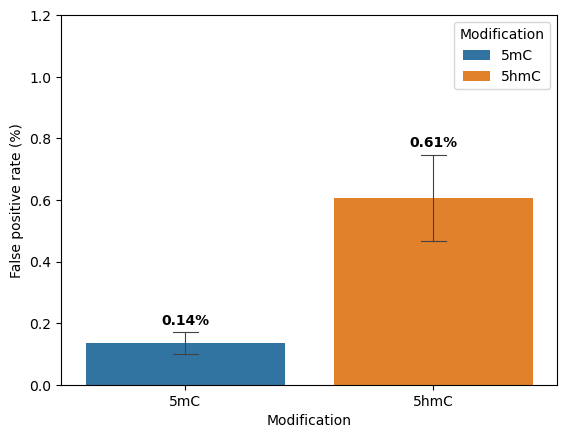

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import string

fig, ax = plt.subplots()

sns.barplot(both, x="Modification", y="False positive rate (%)", 
            capsize=.1, errwidth=.8,
            estimator="mean", errorbar=("se", 1),
            hue="Modification", dodge=False, 
            ax=ax)

ax.text(0, both.query("Modification == '5mC'")["False positive rate (%)"].max() + 0.025, 
        f"{round(mc_mean, 2)}%", 
             c="k", ha="center", fontweight="bold")
ax.text(1, both.query("Modification == '5hmC'")["False positive rate (%)"].max() + 0.025, 
        f"{round(hmc_mean, 2)}%", 
             c="k", ha="center", fontweight="bold")

ax.set_ylim(0, 1.2)


## Figure


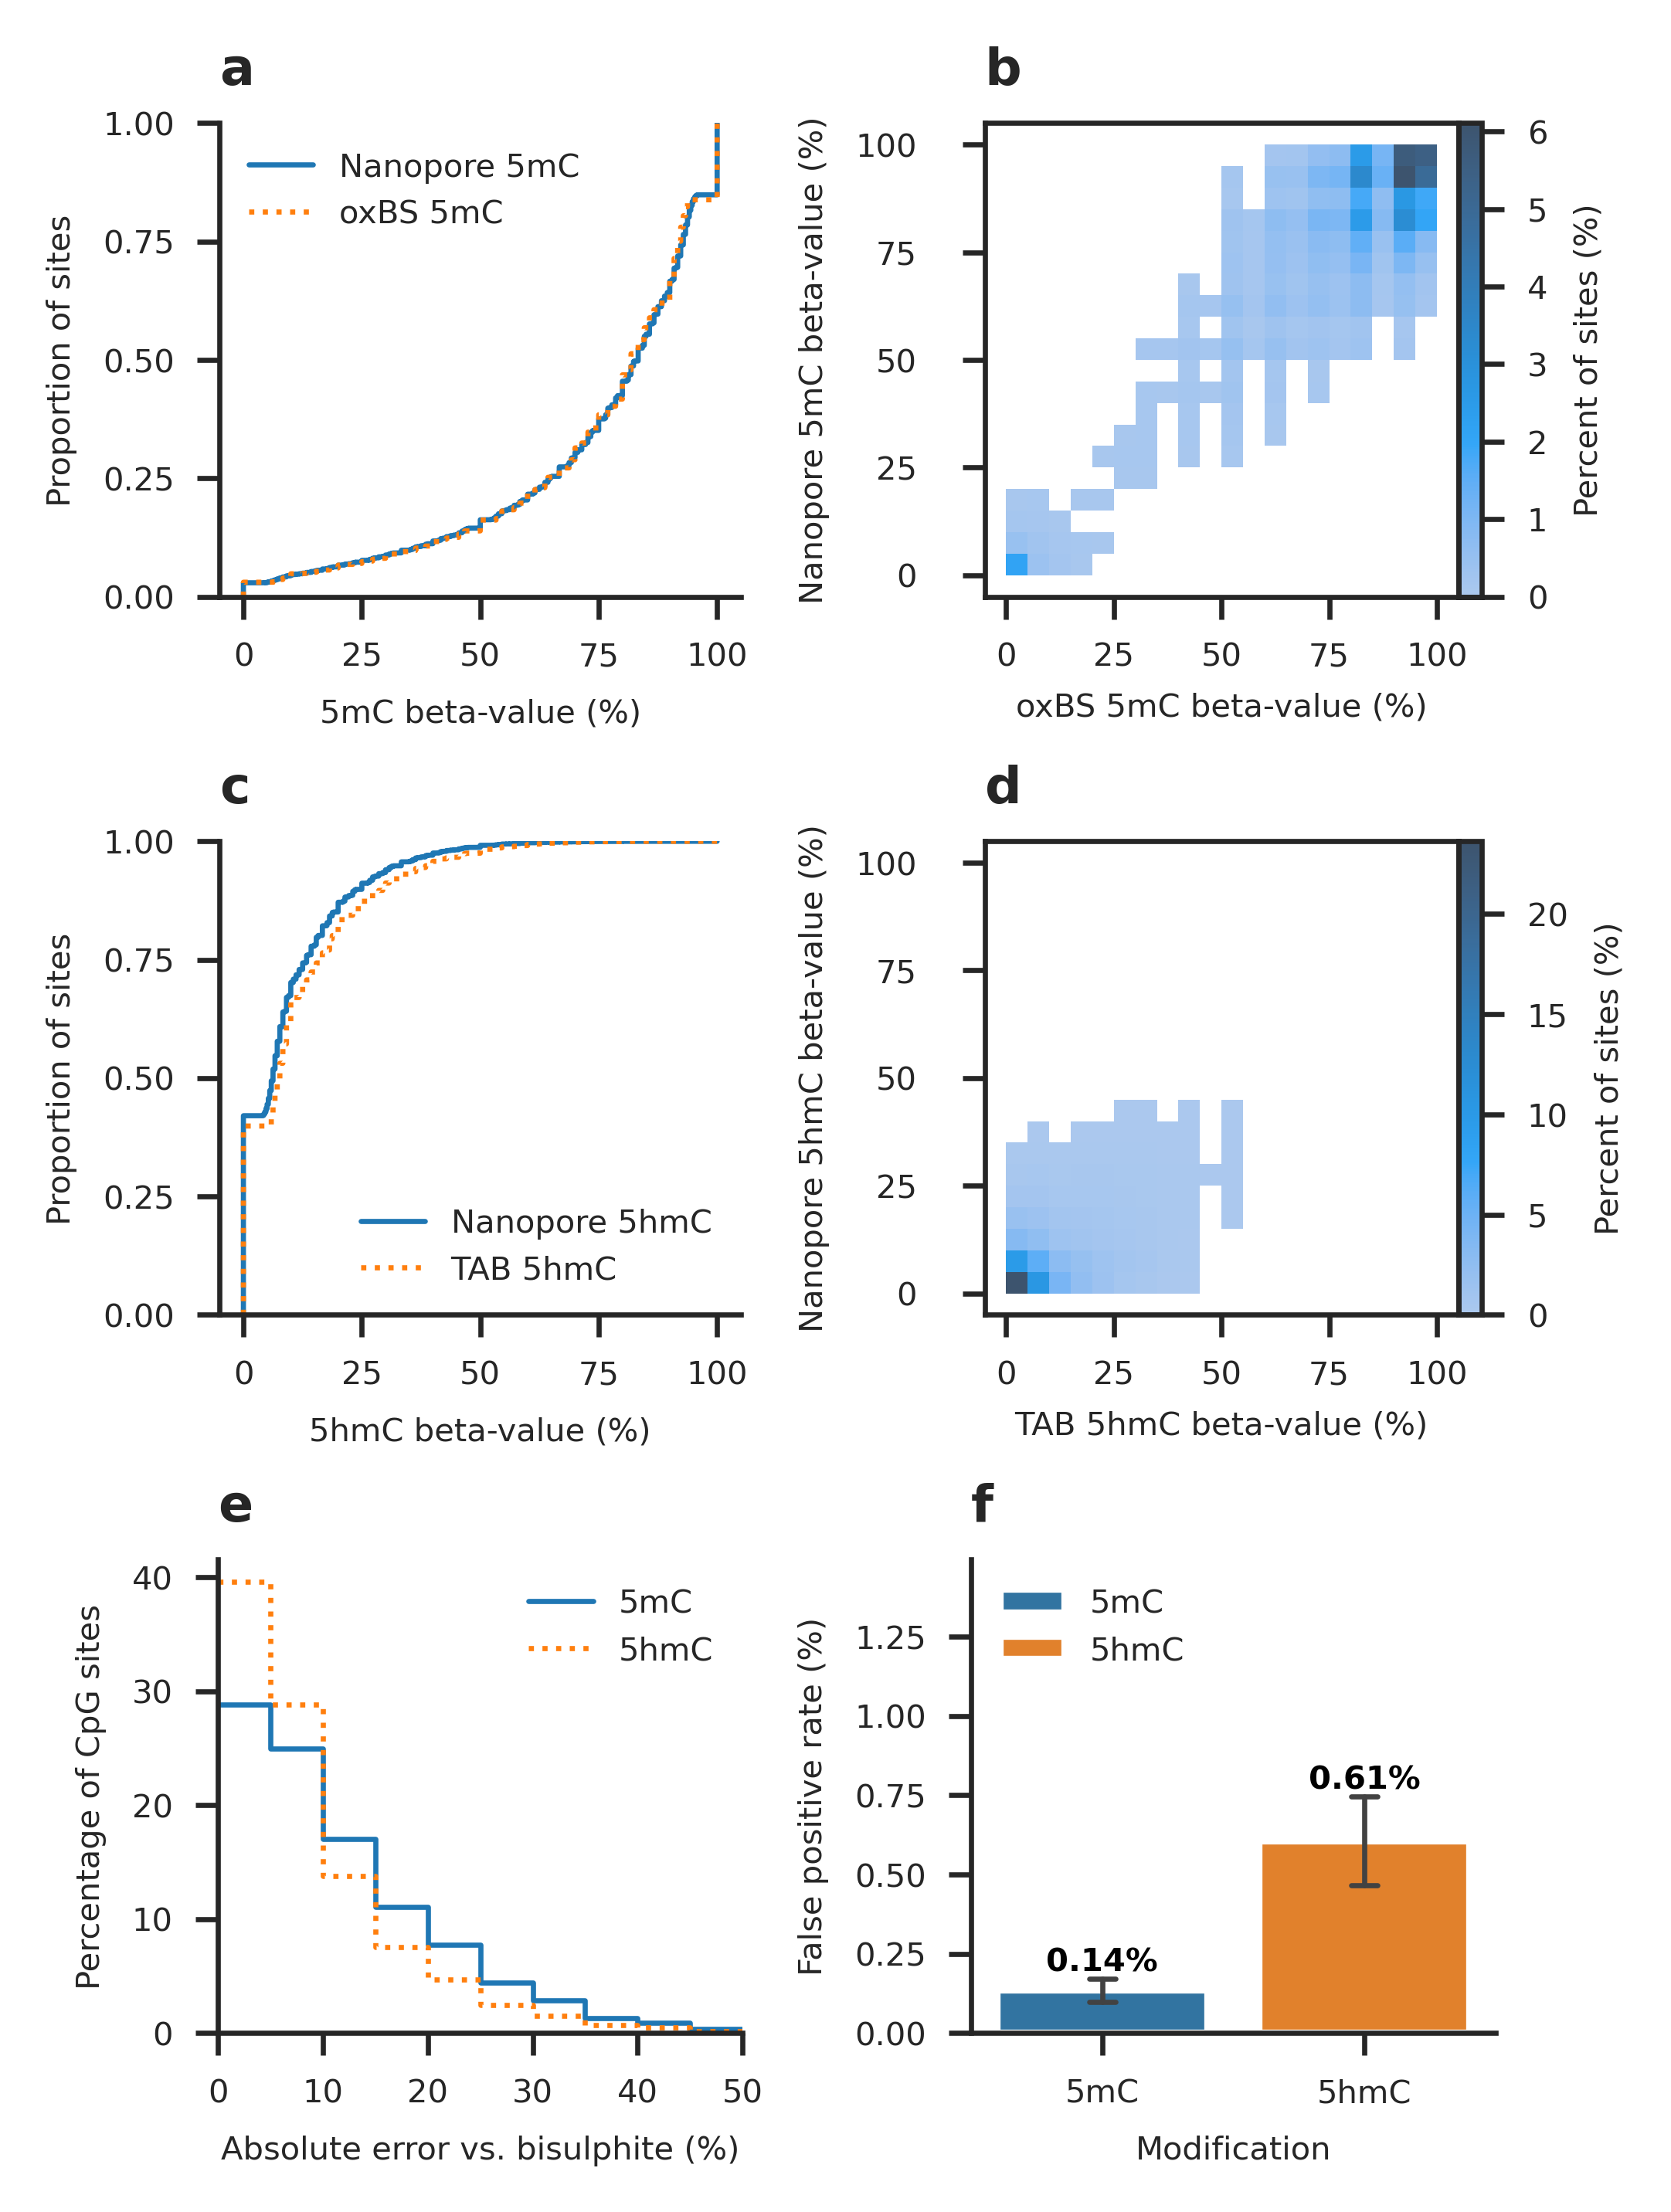

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import string

sns.set_style("ticks")
mpl.rc('font', size=5)

fig, axes = plt.subplots(3, 2, figsize=(89/25.4, 120/25.4), dpi=600)

value_vars = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_oxBS"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_TAB"]]
labels = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for df, value_var, label, row in zip([prom_oxbs_data, prom_tab_data], value_vars, labels, axes[:4]):
    # Col 1 # 
    ecdf = df.melt(
            id_vars=["Chromosome", "Start", "End"], 
            value_vars=value_var,
            value_name="percentMeth",
            var_name="method")
        
    ax1 = row[0]
    
    line_colors = list(sns.color_palette(n_colors=2).as_hex())
    for var, ls, c, label in zip(value_var, ["-", ":"], line_colors, label):
        sns.ecdfplot(ecdf.query(f"method == '{var}'"),
            x="percentMeth", lw=0.8, ls=ls, color=c, label=label, 
            ax=ax1)
           
    ax1.set_aspect(100)
    ax1.set_xticks(np.arange(0, 125, 25))
    ax1.set_yticks(np.arange(0, 1.25, 0.25))
    ax1.set_ylabel("Proportion of sites")
    
    # Col 2 # 
    ax2 = row[1]
    div = make_axes_locatable(ax2)
    cax = div.append_axes("right", size="5%", pad=0)

    sns.histplot(df, y=value_var[0], x=value_var[1], 
                 stat="percent", thresh=0.1, binwidth=5, 
                 cbar=True, cbar_kws={
                    "label" : "Percent of sites (%)",
                    "pad" : 0,
                    "format" : "%0i"
                    }, 
                 ax=ax2, cbar_ax=cax) 
    
    ax2.set_aspect("equal")
    ax2.set_yticks(np.arange(0, 125, 25))
    ax2.set_xticks(np.arange(0, 125, 25))
    ax2.tick_params(axis='y', which='major', pad=7)

axes = axes.flatten() 

# Ax formatting # 
    
axes[0].set_xlabel("5mC beta-value (%)")
axes[2].set_xlabel("5hmC beta-value (%)")
axes[0].legend(title=None, loc="upper left", frameon=False)
axes[2].legend(title=None, loc="lower right", frameon=False)
    
axes[1].set_xlabel("oxBS 5mC beta-value (%)", labelpad=3)
axes[1].set_ylabel("Nanopore 5mC beta-value (%)")
axes[3].set_xlabel("TAB 5hmC beta-value (%)", labelpad=3)
axes[3].set_ylabel("Nanopore 5hmC beta-value (%)")

# Panels 5 # 

for df, mod, ls in zip([prom_oxbs_data, prom_tab_data], [["5mC", "oxBS"], ["5hmC", "TAB"]], ["-", ":"]):
    try: 
        df = df.assign(total_modification = lambda r: r["percentMeth_5mC_Nanopore"] + r["percentMeth_5hmC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"]))

    except: 
        df = df.assign(total_modification = lambda r: r["percentMeth_5hmC_Nanopore"] + r["percentMeth_5mC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"])) 
              
    sns.histplot(df, x="abs_diff", 
                 stat="percent", binwidth=5, 
                 label=f"{mod[0]}",
                 lw=.8, ls=ls, element="step", fill=False, 
                 ax=axes[4])
    
axes[4].legend(frameon=False)
axes[4].set_xlabel("Absolute error vs. bisulphite (%)")
axes[4].set_ylabel("Percentage of CpG sites")
axes[4].set_xlim((0, 50))


# Panel 6 # 

sns.barplot(both, x="Modification", y="False positive rate (%)", 
            capsize=.1, errwidth=.8,
            estimator="mean", errorbar=("se", 1),
            hue="Modification", dodge=False, 
            ax=axes[5])
sns.move_legend(axes[5], loc="upper left", title=None, frameon=False)

axes[5].text(0, both.query("Modification == '5mC'")["False positive rate (%)"].max() + 0.025, 
        f"{round(mc_mean, 2)}%", 
        c="k", ha="center", fontweight="bold")
axes[5].text(1, both.query("Modification == '5hmC'")["False positive rate (%)"].max() + 0.025, 
        f"{round(hmc_mean, 2)}%", 
        c="k", ha="center", fontweight="bold")

axes[5].set_ylim(0, both.query("Modification == '5hmC'")["False positive rate (%)"].max()*2)

# Figure # 

for ax, letter in zip(axes, list(string.ascii_lowercase[:6])):
    ax.set_title(letter, loc="left", fontsize=8, fontweight="bold")

sns.despine()

for ax in [axes[1], axes[3]]:
    sns.despine(ax=ax, top=False, right=False)

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

Deviation as a factor of total modification

In [ ]:

box_df = prom_tab_data.copy()
box_df = box_df.assign(total_modification = lambda r: r["percentMeth_5hmC_Nanopore"] + r["percentMeth_5mC"],
                       abs_diff = lambda r: np.abs(r[f"percentMeth_{mod[0]}_{mod[1]}"] - r[f"percentMeth_{mod[0]}_Nanopore"]))       

box_df["mod_cat"] = pd.cut(box_df["total_modification"], 11, labels=np.arange(0, 110, 10))
sns.boxplot(box_df, x="mod_cat", y="abs_diff", 
            linewidth=.5, palette="Blues", 
            fliersize=.025, flierprops={"marker" : "x"},
            ax=axes[5])

axes[5].set_xticks(ticks=range(0, 11, 2))
axes[5].set_xlabel("Total percentage modification (%)")
axes[5].set_ylabel("Absolute deviation (%)")

In [7]:
mc_eg_df = prom_oxbs_data.copy()
mc_eg_df = mc_eg_df.assign(abs_diff = lambda r: np.abs(r[f"percentMeth_5mC_oxBS"] - r[f"percentMeth_5mC_Nanopore"]))   

In [11]:
len(mc_eg_df.query("abs_diff >= 25"))/len(mc_eg_df)

0.10293067956236374

In [6]:
len(box_df.query("abs_diff >= 25"))/len(box_df)

0.05530861207436317

## CpG level stats

In [2]:
from common import compareStats
import common 
import pandas as pd

prom_oxbs_data = pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv")
prom_tab_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

In [3]:
from scipy import stats
import numpy as np

stats.permutation_test([prom_oxbs_data["percentMeth_5mC_oxBS"], prom_oxbs_data["percentMeth_5mC_Nanopore"]])

In [4]:
compareStats(prom_oxbs_data["percentMeth_5mC_oxBS"], prom_oxbs_data["percentMeth_5mC_Nanopore"])

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Pearson                                                  [0.824, 0.0]
Spearman                                                 [0.648, 0.0]
Kendall                                                  [0.489, 0.0]
Shapiro-Wilk                                               [0.0, 0.0]
RMSE                                                        15.068792
Mean Absolute Error                                         11.368923
Median Absolute Error                                            9.09
KS                                        [0.061539449460495166, 0.0]
MW                                            [45066434258748.0, 0.0]
CVM                      [1835.6261182068847, 3.6815362214337455e-07]
AD                                        [11087.472862622644, 0.001]
dtype: object

In [6]:
compareStats(prom_tab_data["percentMeth_5hmC_TAB"], prom_tab_data["percentMeth_5hmC_Nanopore"])

/mnt/data1/doh28/analyses/mouse_hydroxymethylome_analysis/common.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad = stats.anderson_ksamp([x, y])
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Pearson                                                  [0.556, 0.0]
Spearman                                                  [0.44, 0.0]
Kendall                                                  [0.342, 0.0]
Shapiro-Wilk                                               [0.0, 0.0]
RMSE                                                        11.963354
Mean Absolute Error                                          8.232789
Median Absolute Error                                            6.67
KS                                         [0.11306417254500561, 0.0]
MW                                            [57880404782922.5, 0.0]
CVM                      [12658.402416331228, 1.0782967392319875e-06]
AD                                         [84360.40624183079, 0.001]
dtype: object

# Macro-level 5hmC comparison

In [46]:
import pandas as pd
from MultisiteTools import *
from common import *

prom_tab_comp = CpGRange(pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv"))
    
# prom_tab_comp = makeCpGRange(nano_path, tab_path)
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_tab_comp.group_by_annotation("features", "feature_references/genic/").enrichment_over_mean(native=False).df
    all_cgi = prom_tab_comp.group_by_annotation("CGI", "feature_references/cgi/").enrichment_over_mean(native=False).df
    all_genes = prom_tab_comp.group_by_annotation("genes", "feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(native=False).df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])
features_genes_cgi = features_genes_cgi.query("log2enrichment_5hmC_TAB > -inf & log2enrichment_5hmC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")
genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


## Figure

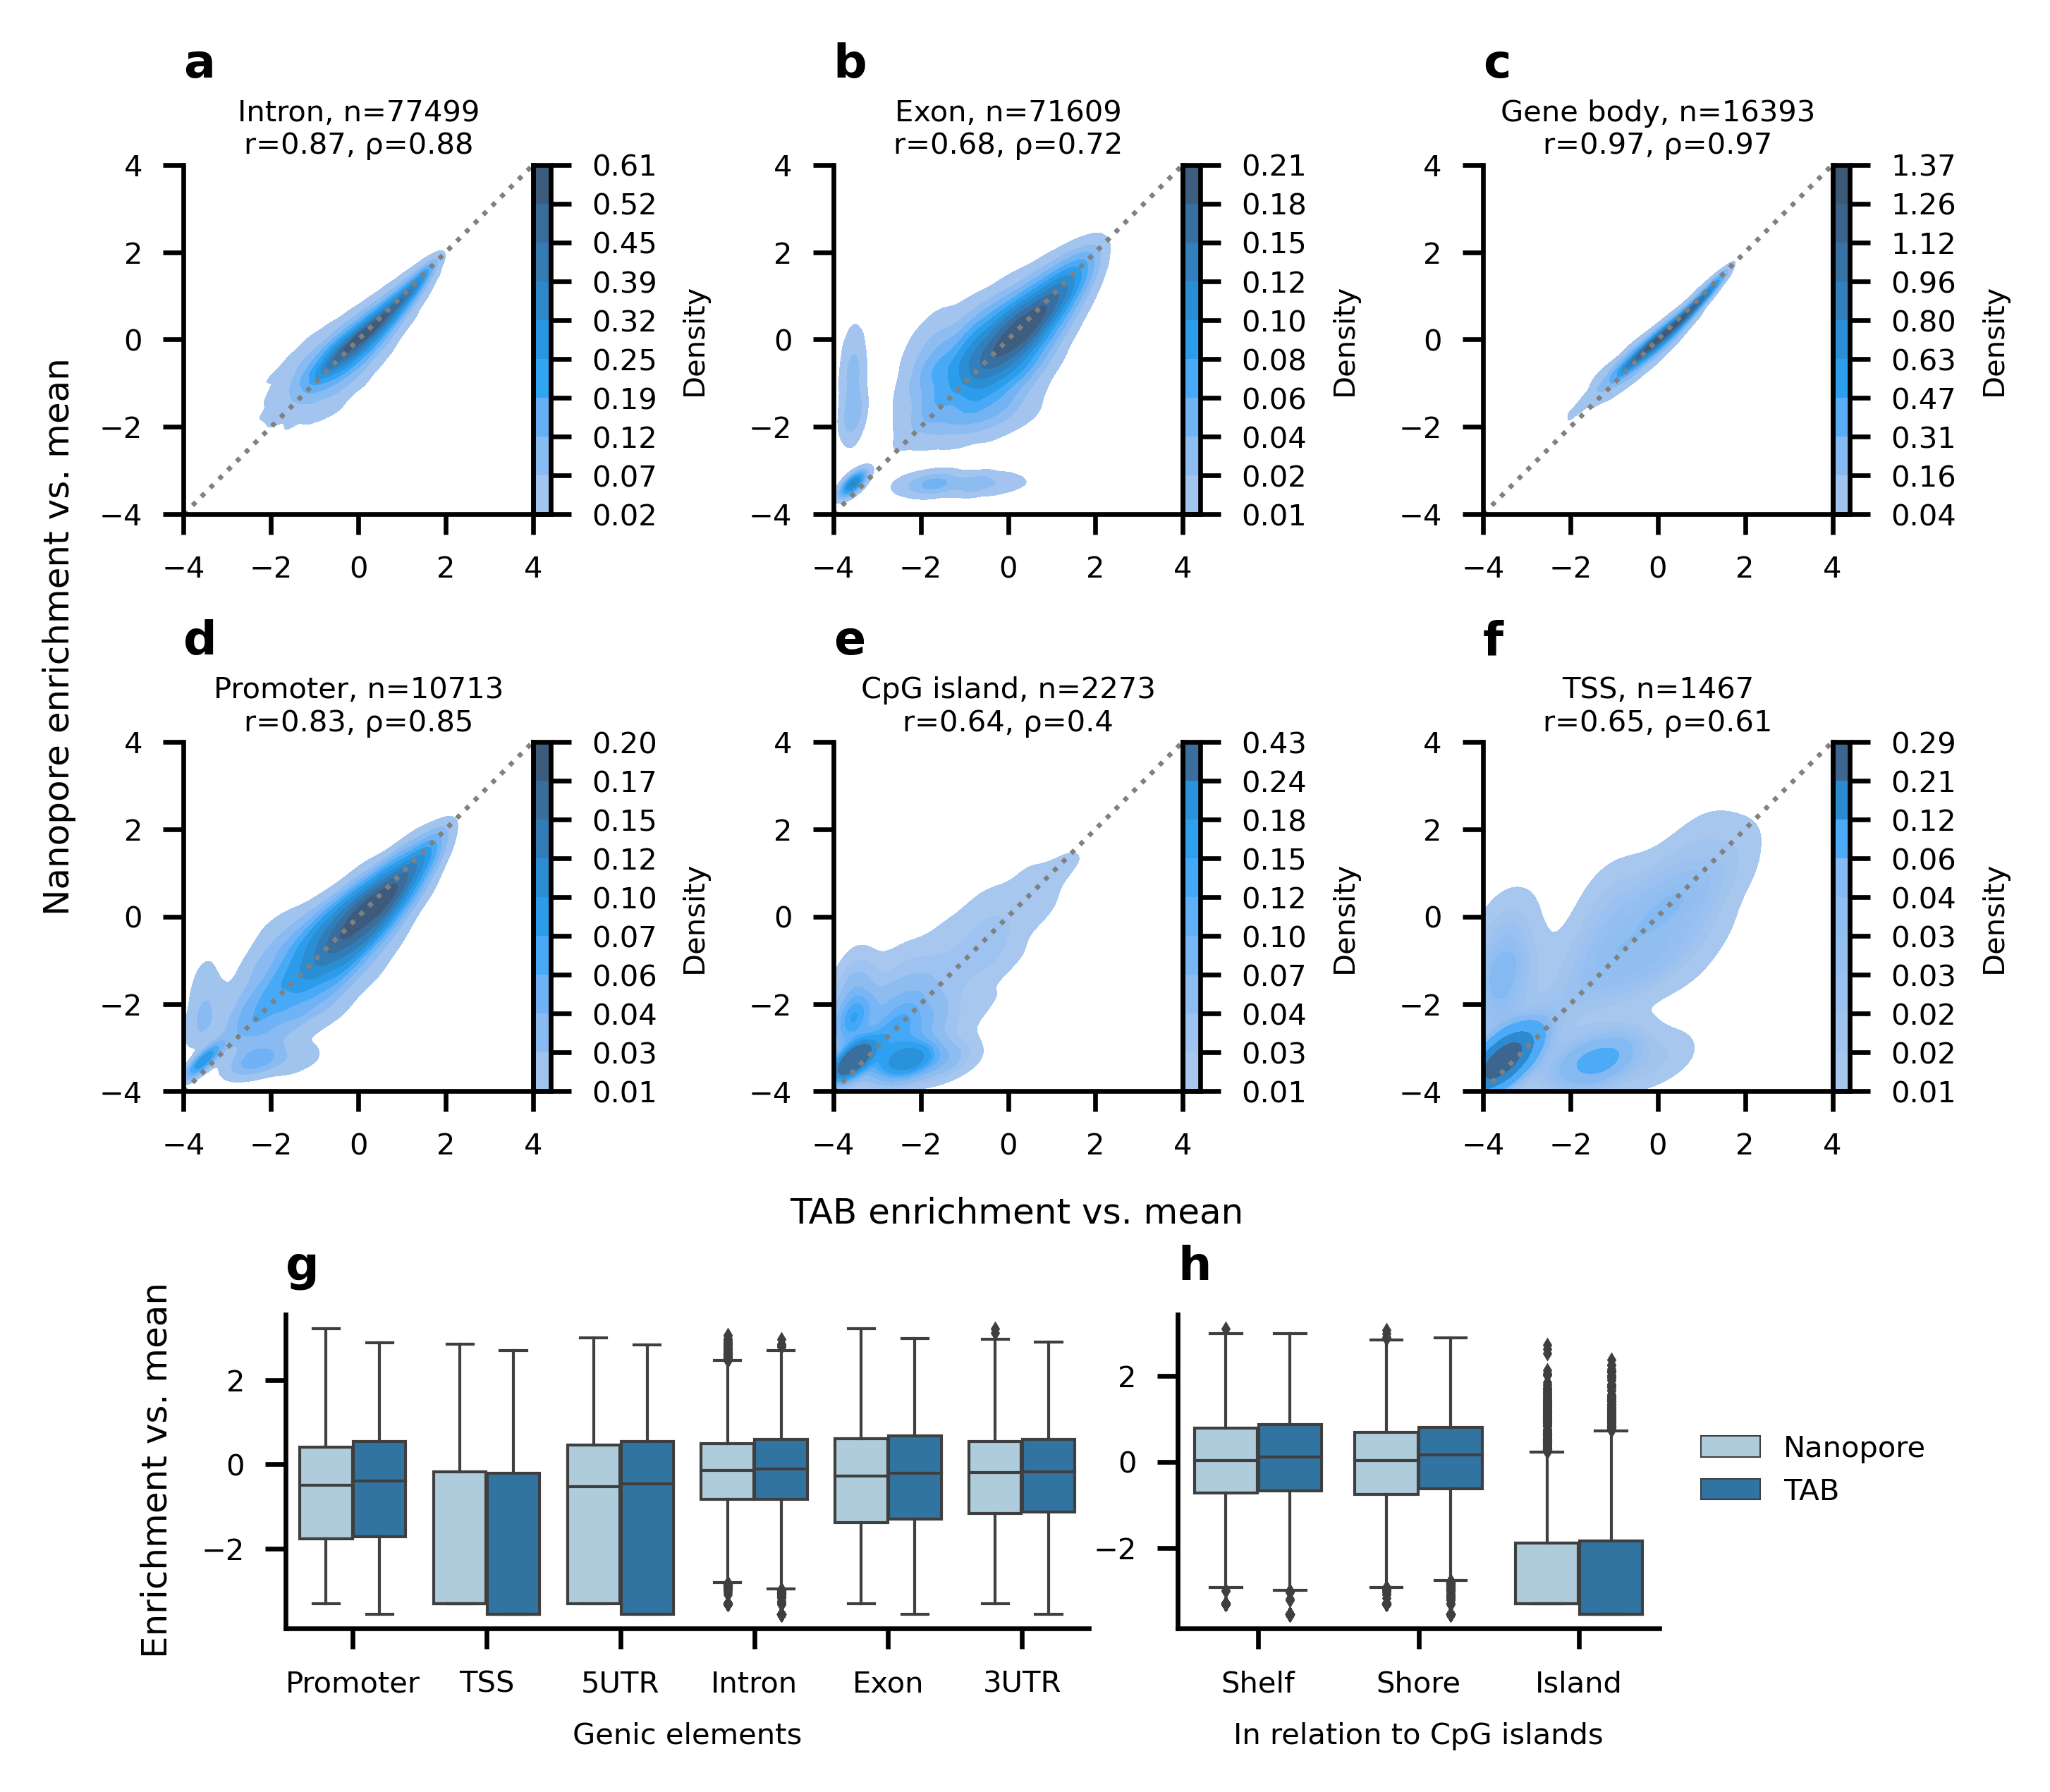

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(120/25.4, 110/25.4), dpi=600, layout="constrained")
gs = GridSpec(2, 1, fig, height_ratios=(3, 1))
mpl.rc('font', size=5)

sfig1 = fig.add_subfigure(gs[0, :])
gs1 = GridSpec(2, 3, sfig1)
ax1 = sfig1.add_subplot(gs1[0, 0])
ax2 = sfig1.add_subplot(gs1[0, 1])
ax3 = sfig1.add_subplot(gs1[0, 2])
ax4 = sfig1.add_subplot(gs1[1, 0])
ax5 = sfig1.add_subplot(gs1[1, 1])
ax6 = sfig1.add_subplot(gs1[1, 2])

sfig2 = fig.add_subfigure(gs[1, :])
gs2 = GridSpec(1, 3, width_ratios=(2.5, 1.5, 0.15))

ax7 = sfig2.add_subplot(gs2[0, 0])
ax8 = sfig2.add_subplot(gs2[0, 1])

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.kdeplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                fill=True, common_norm=False, 
                cbar=True, cbar_kws={
                    "label" : "Density", 
                    "pad" : 0,
                    "format" : "%2.2f"},
                ax=hist_axes[i], cbar_ax=cax)

    hist_axes[i].set_aspect("equal")
    
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)

    hist_axes[i].set_ylim((-4, 4))
    hist_axes[i].set_xlim((-4, 4))

    hist_axes[i].set_yticks(ticks=range(-4, 5, 2))
    hist_axes[i].set_xticks(ticks=range(-4, 5, 2))
    hist_axes[i].plot((-4, 4), (-4, 4), ls=":", lw=0.8, c="grey")

    pearson = stats.pearsonr(hist_df["log2enrichment_5hmC_TAB"], hist_df["log2enrichment_5hmC_Nanopore"]).statistic
    spearman = stats.spearmanr(hist_df["log2enrichment_5hmC_TAB"], hist_df["log2enrichment_5hmC_Nanopore"]).statistic

    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}\nr={round(pearson, 2)}, \u03C1={round(spearman, 2)}", 
                           loc="center", fontsize=5, va="center")
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold", y=1.15)

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5hmC", 
                hue="method", palette="Paired", dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel(None)
    ax.get_legend().set_visible(False)

barplot_handles, barplot_labels = ax7.get_legend_handles_labels()

sfig2.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.98, .65), frameon=False)

sfig1.supylabel("Nanopore enrichment vs. mean", x=0)
sfig2.supylabel("Enrichment vs. mean", x=.05)

sfig1.supxlabel("TAB enrichment vs. mean")

engine = fig.get_layout_engine()
engine.set(rect=(0, 0.075, .975, .9))

sns.despine()

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros_s.png", dpi=600)

## Stats

In [47]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from common import compareStats
import warnings

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"] 

features_series = []
for feature in feature_order:
    hist_df = all_hists.query(f"feature_type == '{feature}'")
    median_count = hist_df["CpG_count"].median()

    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    x = hist_df["log2enrichment_5hmC_TAB"]
    y = hist_df["log2enrichment_5hmC_Nanopore"]

    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=UserWarning)
        feat_stats = compareStats(x, y)
    
    feature_series = pd.concat([pd.Series({"Feature type" : feature, 
                                           "CpG median" : int(median_count),
                                           "Nanopore mean" : x.mean(),
                                           "TAB mean" : y.mean()}), 
                                feat_stats])
    features_series.append(feature_series)
    
hmc_stats = pd.DataFrame(features_series)

In [48]:
hmc_stats

Feature type  CpG median  Nanopore mean  TAB mean  Pearson_r  Spearman_p  \
0       Intron          10      -0.037594 -0.059810       0.87        0.88   
1         Exon           3      -0.370257 -0.379830       0.68        0.72   
2    Gene body          47       0.017540  0.009196       0.97        0.97   
3     Promoter           5      -0.633469 -0.700375       0.83        0.85   
4          TSS           2      -1.957038 -1.885551       0.65        0.61   
5   CpG island           5      -2.417812 -2.398431       0.64        0.40   

  Correlation_p_values  Kendall      RMSE  Mean Absolute Error  \
0           [0.0, 0.0]     0.71  0.432076             0.310635   
1           [0.0, 0.0]     0.54  1.027237             0.734512   
2           [0.0, 0.0]     0.85  0.201149             0.148486   
3           [0.0, 0.0]     0.66  0.788865             0.588396   
4           [0.0, 0.0]     0.50  1.395765             1.001434   
5           [0.0, 0.0]     0.31  0.977113             0.765270   

   Median Absolute Error                                             KS  \
0               0.223011   [0.03076168724757733, 2.727918533136954e-32]   
1               0.506040   [0.0633020988981832, 3.579920468112737e-125]   
2               0.112172    [0.03647898493259316, 6.52540676046638e-10]   
3               0.440677   [0.06095398114440399, 9.664802301016102e-18]   
4               0.511519   [0.4730743012951602, 8.133598596186223e-149]   
5               0.599314  [0.3506379234491861, 2.2093831667454032e-124]   

                                      MW  \
0  [3067078559.0, 3.600963702238255e-13]   
1  [2590602751.0, 0.0006488303952375064]   
2    [136718851.0, 0.006018938494021148]   
3    [59250385.0, 3.745517597174553e-05]   
4     [841974.0, 4.0660294866280383e-25]   
5     [2340296.0, 3.113063070149828e-08]   

                                            CVM                           AD  \
0   [12.761074325077061, 3.166127471310176e-09]   [97.90782295250075, 0.001]   
1    [8.987836579293798, 2.626813211392687e-10]  [257.69107151027504, 0.001]   
2   [3.9734604925633903, 7.478042629571746e-10]   [32.46036200415252, 0.001]   
3   [3.1612024324404047, 3.329548692310169e-08]  [47.929795034975776, 0.001]   
4   [40.04639910338284, 1.0794658278356906e-08]   [352.8402974941585, 0.001]   
5  [29.014040083777672, 3.5670629783268737e-09]   [263.1019108842746, 0.001]   

                                       T-Test  
0  [5.162455158555542, 2.440318024503923e-07]  
1   [1.4134909982730597, 0.15751357977446448]  
2   [1.0286373644588038, 0.30365770202862835]  
3  [3.651090790708819, 0.0002617502435133123]  
4  [-1.1592425968719218, 0.24645171179864092]  
5    [-0.570287488018545, 0.5685109217487913]

In [25]:
hmc_stats["Nanopore mean"][5] - hmc_stats["TAB mean"][5]

0.590396842543951

# Macro level 5mC comparison

In [49]:
import pandas as pd
from MultisiteTools import *
from common import *
import warnings

prom_oxbs_comp = CpGRange(pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv"))

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_oxbs_comp.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean().df
    all_cgi = prom_oxbs_comp.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean().df
    all_genes = prom_oxbs_comp.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean().df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])

Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']


In [50]:
features_genes_cgi = features_genes_cgi.query("log2enrichment_5mC_oxBS > -inf & log2enrichment_5mC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")

genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

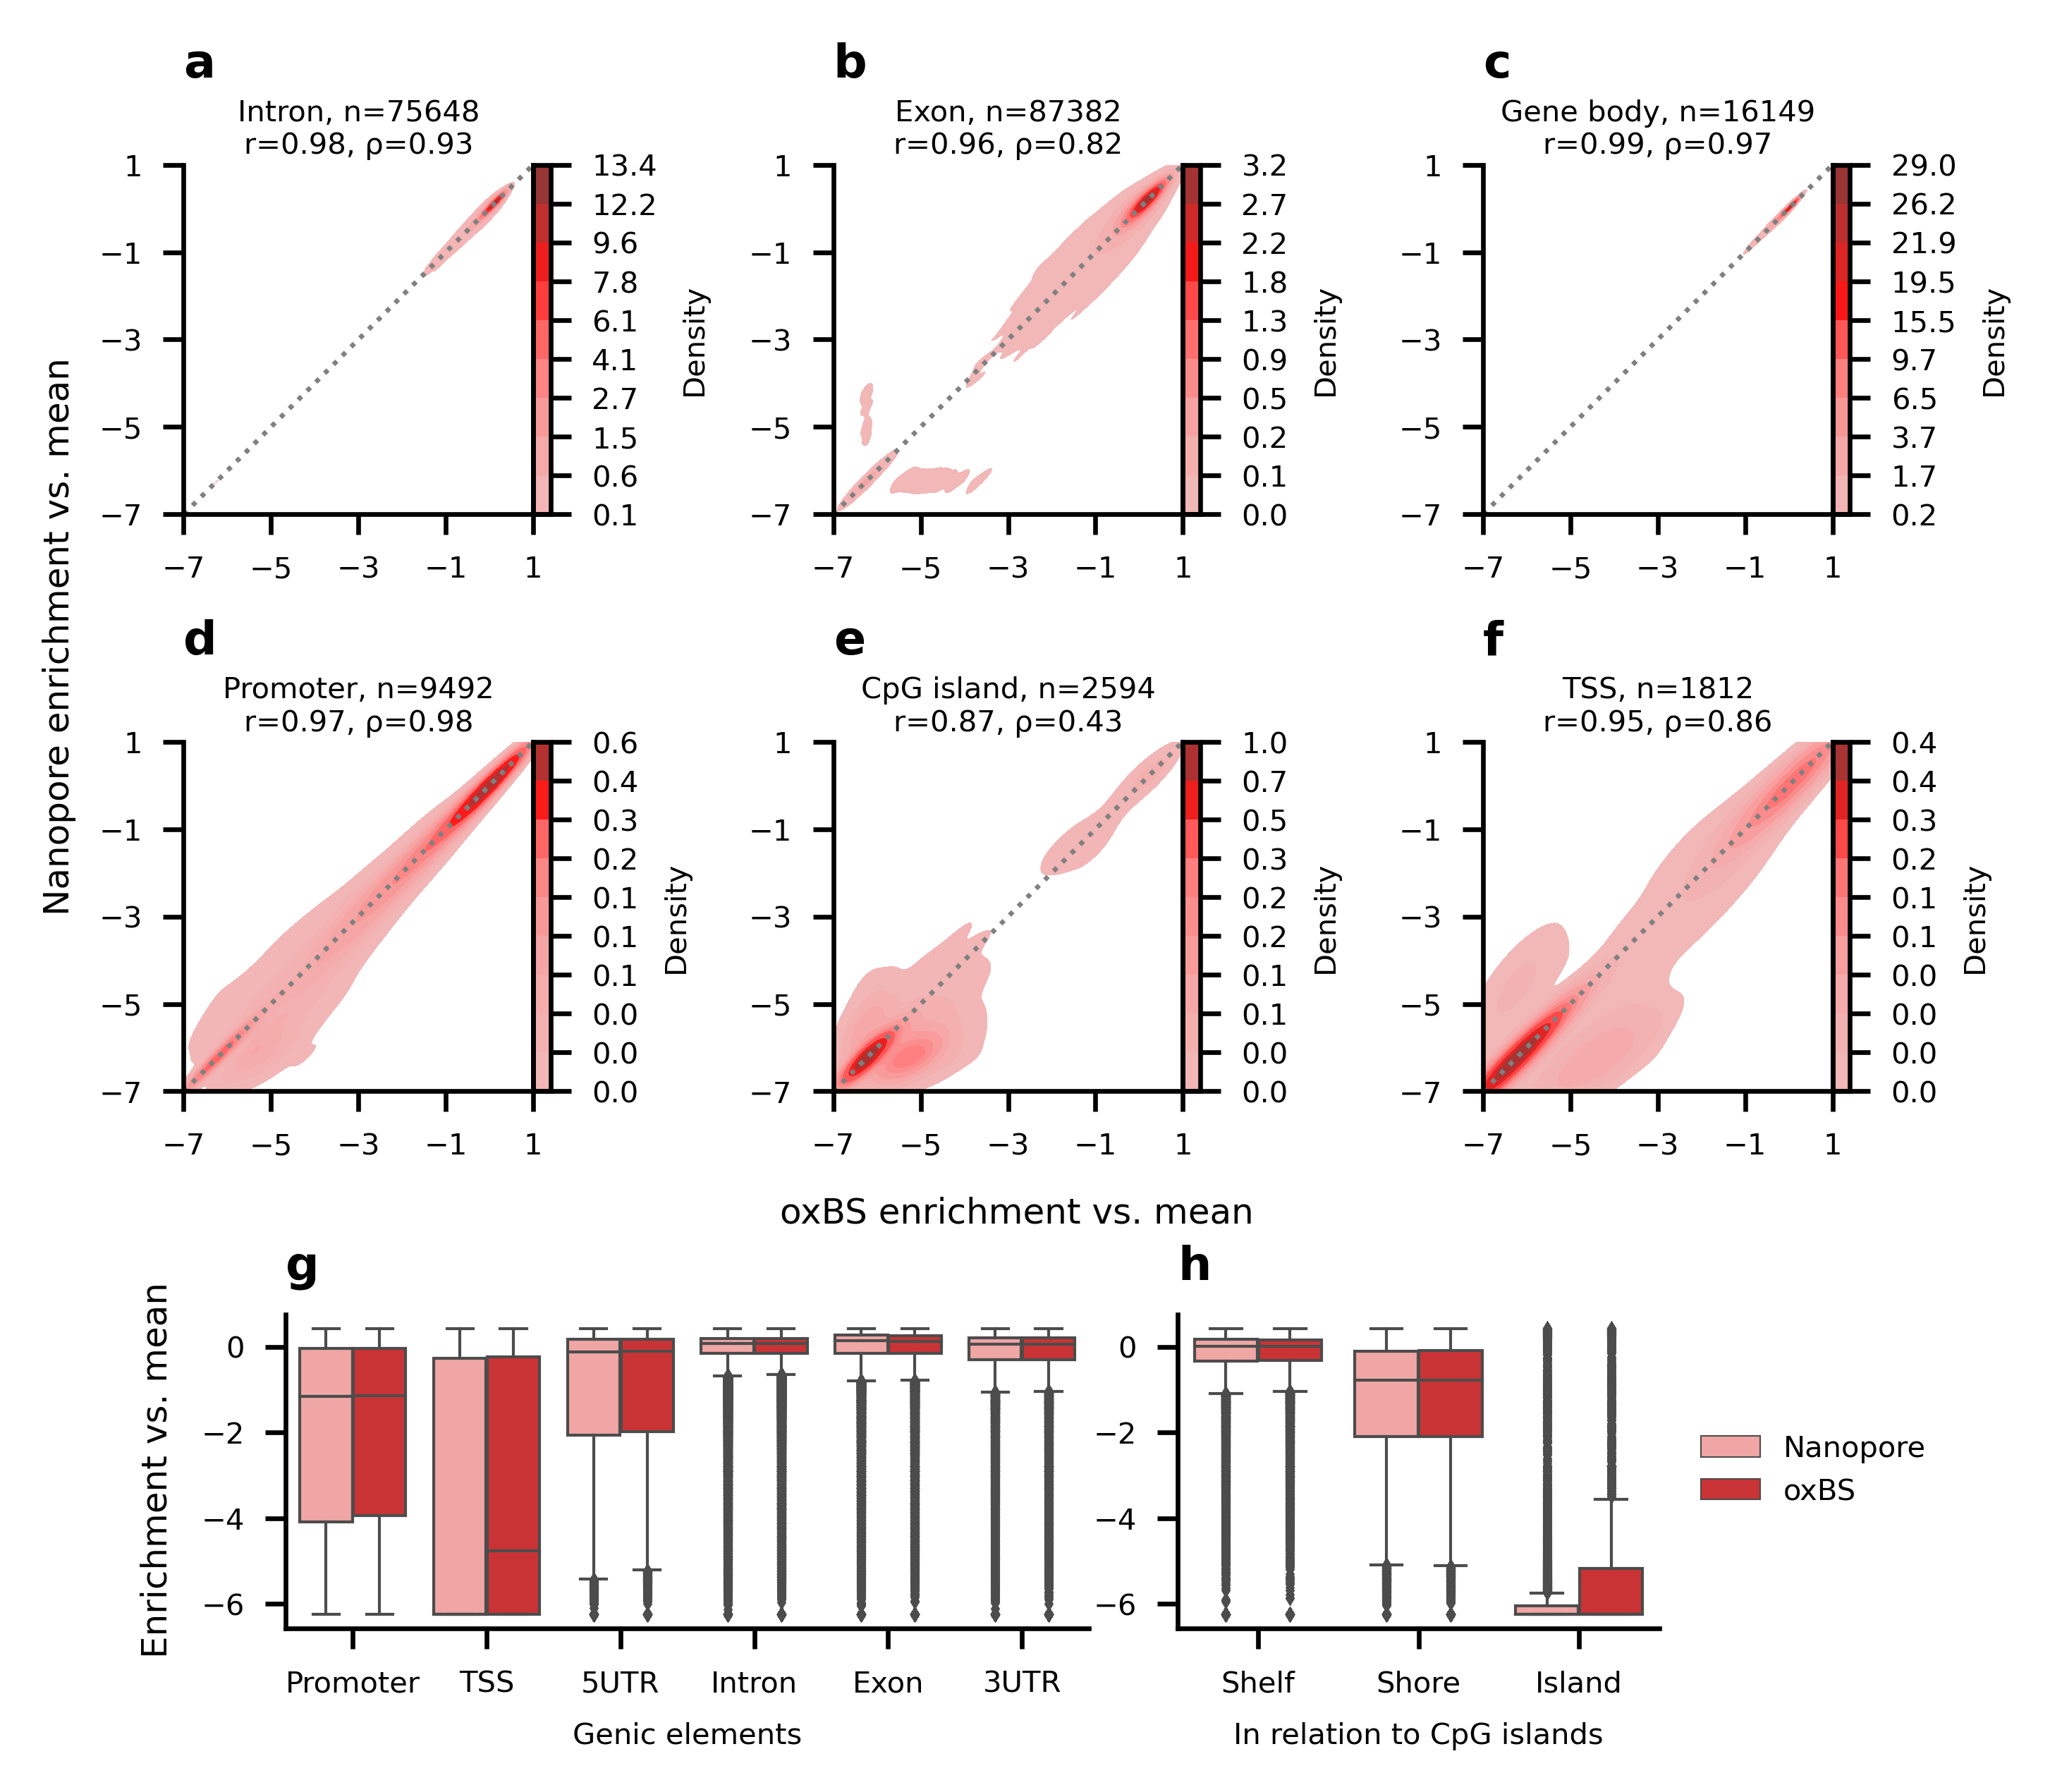

In [22]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(120/25.4, 110/25.4), dpi=600, layout="constrained")
gs = GridSpec(2, 1, fig, height_ratios=(3, 1))
mpl.rc('font', size=5)

sfig1 = fig.add_subfigure(gs[0, :])

gs1 = GridSpec(2, 3, sfig1)

ax1 = sfig1.add_subplot(gs1[0, 0])
ax2 = sfig1.add_subplot(gs1[0, 1])
ax3 = sfig1.add_subplot(gs1[0, 2])
ax4 = sfig1.add_subplot(gs1[1, 0])
ax5 = sfig1.add_subplot(gs1[1, 1])
ax6 = sfig1.add_subplot(gs1[1, 2])

sfig2 = fig.add_subfigure(gs[1, :])
gs2 = GridSpec(1, 3, width_ratios=(2.5, 1.5, 0.15))

ax7 = sfig2.add_subplot(gs2[0, 0])
ax8 = sfig2.add_subplot(gs2[0, 1])

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

min_list = []
max_list = []

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.kdeplot(hist_df, x="log2enrichment_5mC_oxBS", y="log2enrichment_5mC_Nanopore", 
                fill=True, common_norm=False, color="red",
                cbar=True, cbar_ax=cax, cbar_kws={"label" : "Density", 
                                                  "pad" : 0,
                                                  "format" : "%2.1f"},
                ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)

    pearson = stats.pearsonr(hist_df["log2enrichment_5mC_oxBS"], hist_df["log2enrichment_5mC_Nanopore"]).statistic
    spearman = stats.spearmanr(hist_df["log2enrichment_5mC_oxBS"], hist_df["log2enrichment_5mC_Nanopore"]).statistic

    min_list.extend([hist_df['log2enrichment_5mC_oxBS'].min(), hist_df['log2enrichment_5mC_Nanopore'].min()])
    max_list.extend([hist_df['log2enrichment_5mC_oxBS'].max(), hist_df['log2enrichment_5mC_Nanopore'].max()])

    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}\nr={round(pearson, 2)}, \u03C1={round(spearman, 2)}", 
                           loc="center", fontsize=5, va="center")    
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold", y=1.15)

for ax in hist_axes:
    smallest = math.floor(min(min_list))
    biggest = math.ceil(max(max_list))
    
    ax.set_xlim(smallest, biggest)
    ax.set_ylim(smallest, biggest)
    ax.set_xticks(ticks=range(smallest, biggest + 1, 2))
    ax.set_yticks(ticks=range(smallest, biggest + 1, 2))

    ax.plot((smallest, biggest, 2), (smallest, biggest, 2), ls=":", lw=0.8, c="grey")

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5mC", 
                hue="method", palette=sns.color_palette("Paired")[4:6], dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel(None)
    ax.get_legend().set_visible(False)
    
barplot_handles, barplot_labels = ax7.get_legend_handles_labels()
sfig2.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.98, .65), frameon=False)

sfig1.supylabel("Nanopore enrichment vs. mean", x=0)
sfig2.supylabel("Enrichment vs. mean", x=.05)

sfig1.supxlabel("oxBS enrichment vs. mean")

engine = fig.get_layout_engine()
engine.set(rect=(0, 0.075, .975, .9))

sns.despine()

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros_mc_s.png", dpi=600)

In [4]:
high_5mc_cgis = all_hists.query("feature_type == 'CpG island' & CpG_count >= 10 & log2enrichment_5mC_Nanopore > 0 & log2enrichment_5mC_oxBS > 0")
high_5mc_cgis["IGV"] = high_5mc_cgis.Chromosome + ":" + high_5mc_cgis.Start.map(str) + "-" + high_5mc_cgis.End.map(str)

/tmp/ipykernel_3675219/3493141135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_5mc_cgis["IGV"] = high_5mc_cgis.Chromosome + ":" + high_5mc_cgis.Start.map(str) + "-" + high_5mc_cgis.End.map(str)


## Stats

In [51]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from common import compareStats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"] 

features_series = []
for feature in feature_order:
    hist_df = all_hists.query(f"feature_type == '{feature}'")
    median_count = hist_df["CpG_count"].median()

    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    x = hist_df["log2enrichment_5mC_oxBS"]
    y = hist_df["log2enrichment_5mC_Nanopore"]

    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=UserWarning)
        feat_stats = compareStats(x, y)
    
    feature_series = pd.concat([pd.Series({"Feature type" : feature, 
                                           "CpG median" : int(median_count)}), 
                                feat_stats])
    features_series.append(feature_series)

pd.DataFrame(features_series)

Feature type  CpG median  Pearson_r  Spearman_p Correlation_p_values  \
0       Intron           9       0.98        0.93           [0.0, 0.0]   
1         Exon           2       0.96        0.82           [0.0, 0.0]   
2    Gene body          39       0.99        0.97           [0.0, 0.0]   
3     Promoter           5       0.97        0.98           [0.0, 0.0]   
4          TSS           2       0.95        0.86           [0.0, 0.0]   
5   CpG island           6       0.87        0.43           [0.0, 0.0]   

   Kendall      RMSE  Mean Absolute Error  Median Absolute Error  \
0     0.78  0.128790             0.067426               0.042141   
1     0.65  0.430203             0.204517               0.097224   
2     0.87  0.056729             0.032157               0.021649   
3     0.88  0.549732             0.334442               0.159941   
4     0.78  0.859693             0.411449               0.000765   
5     0.36  0.751411             0.489169               0.273646   

                                              KS  \
0  [0.025010575296108284, 5.498342972901445e-21]   
1   [0.04776727472477169, 4.505839545818251e-87]   
2    [0.017214688215988594, 0.01650815741173876]   
3   [0.1389591234723978, 2.7958831609447557e-80]   
4                 [0.6169977924944813, 1.4e-322]   
5                      [0.6649961449498843, 0.0]   

                                       MW  \
0  [2813444521.0, 1.7497843347779865e-08]   
1   [3744196565.0, 2.941444612427013e-12]   
2       [128852001.0, 0.0655033107929842]   
3     [46245940.0, 0.0015191786875052929]   
4     [2280606.0, 3.1365867649942613e-96]   
5     [5124495.0, 3.693193400267193e-246]   

                                            CVM  \
0    [6.525879141281621, 4.741251835582716e-11]   
1  [12.544089691749832, 2.3774863189274242e-09]   
2      [0.565994253939607, 0.02718376759714891]   
3   [6.3748969816929275, 2.893640882462023e-11]   
4  [101.35029431884072, 3.1455921645218154e-08]   
5  [181.29355593597472, 5.6026844164058787e-08]   

                                           AD  \
0                   [70.2457600285118, 0.001]   
1                  [261.4575647114082, 0.001]   
2  [5.759173198833407, 0.0018720411757990696]   
3                 [166.69582086135028, 0.001]   
4                  [870.2852272176585, 0.001]   
5                 [1589.9520882289955, 0.001]   

                                       T-Test  
0  [-0.03958506792479737, 0.9684239844093555]  
1    [0.9153055679679495, 0.3600324997879981]  
2    [-0.306837526440343, 0.7589690213651334]  
3   [1.8215996888580044, 0.06853147916490061]  
4   [1.7038071102191714, 0.08850290653652433]  
5  [6.485541042510569, 9.662703129227852e-11]

# Interassay replicability using MinION WGS data

In [1]:
import pandas as pd
from common import *

try:
    min_1 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_07_08_23_mq60.tsv")
    min_2 = pd.read_csv("data_tables/data_files/processed/cbm1_wgs_26_06_23_mapq60.tsv")
    prom = pd.read_csv("data_tables/data_files/processed/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.tsv")

except:
    print("Files not found.")
    min_1 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_26_06_23_mapq60.bed", 1, False, False)
    min_2 = readModkit("data_tables/data_files/nanopore_min/cbm1_wgs_07_08_23_mq60.bed", 1, False, False)
    prom = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, False)

In [69]:
min_1.to_csv("data_tables/data_files/processed/cbm1_wgs_07_08_23_mq60.tsv", index=False)
min_2.to_csv("data_tables/data_files/processed/cbm1_wgs_26_06_23_mapq60.tsv", index=False)
prom.to_csv("data_tables/data_files/processed/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.tsv", index=False)

Loading public datasets

In [2]:
tab_df = readBismarkZeroCov("data_tables/data_files/public/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False, False)
oxbs_df = readBismarkZeroCov("data_tables/data_files/public/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False, False)

In [3]:
tab_min_1 = pd.merge(tab_df, min_1, "inner", ["Chromosome", "Start", "End"], suffixes=["_TAB", "_Rep1"])
tab_min_2 = pd.merge(tab_df, min_2, "inner", ["Chromosome", "Start", "End"], suffixes=["_TAB", "_Rep2"])

In [4]:
ox_min_1 = pd.merge(oxbs_df, min_1, "inner", ["Chromosome", "Start", "End"], suffixes=["_oxBS", "_Rep1"])
ox_min_2 = pd.merge(oxbs_df, min_2, "inner", ["Chromosome", "Start", "End"], suffixes=["_oxBS", "_Rep2"])

In [138]:
tab_min_1_filtered = tab_min_1.query("readCount_TAB > 9 & readCount_Rep1 > 9")
tab_min_2_filtered = tab_min_2.query("readCount_TAB > 9 & readCount_Rep2 > 9")

ox_min_1_filtered = ox_min_1.query("readCount_oxBS > 9 & readCount_Rep1 > 9")
ox_min_2_filtered = ox_min_2.query("readCount_oxBS > 9 & readCount_Rep2 > 9")

## At CpG level

RMSE Min-Min

In [43]:
min_min = pd.merge(min_1, min_2, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_1", "_2"])

In [2]:
def depthRMSEpermutor(df, rc1, rc2): 

    all_depth_dfs = []
    for lim in np.arange(1, 31, 1):
        df_filt = df.query(f"{rc1} > {lim} & {rc2} > {lim}")

        rmse_mc = metrics.mean_squared_error(df_filt["percentMeth_5mC_1"], df_filt["percentMeth_5mC_2"], squared=False)
        rmse_hmc = metrics.mean_squared_error(df_filt["percentMeth_5hmC_1"], df_filt["percentMeth_5hmC_2"], squared=False)

        stat_s_1 = pd.Series({"Threshold" : lim, 
                              "RMSE_5mC" : rmse_mc,
                              "RMSE_5hmC" : rmse_hmc})
        
        all_depth_dfs.append(stat_s_1)

    return pd.DataFrame(all_depth_dfs)


In [60]:
min_rep_comp = depthRMSEpermutor(min_min, "readCount_1", "readCount_2")

In [87]:
min_rep_comp.corr()

Threshold  RMSE_5mC  RMSE_5hmC
Threshold   1.000000 -0.914136  -0.868930
RMSE_5mC   -0.914136  1.000000   0.992711
RMSE_5hmC  -0.868930  0.992711   1.000000

In [64]:
min_1 = min_1.assign(Replicate = "Min. WGS 1")
min_2 = min_2.assign(Replicate = "Min. WGS 2")

mins = pd.concat([min_1, min_2])

RMSE Min-Prom

In [3]:
prom_min_1 = pd.merge(prom, min_1, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Prom", "_Rep1"])
prom_min_2 = pd.merge(prom, min_2, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Prom", "_Rep2"])

In [92]:
from sklearn import metrics

prom_min_1 = prom_min_1.query("readCount_Prom >= 10 & readCount_Rep1 >= 10")
prom_min_2 = prom_min_2.query("readCount_Prom >= 10 & readCount_Rep2 >= 10")

rmses = [metrics.mean_squared_error(prom_min_1["percentMeth_5hmC_Prom"], prom_min_1["percentMeth_5hmC_Rep1"], squared=False), 
        metrics.mean_squared_error(prom_min_2["percentMeth_5hmC_Prom"], prom_min_2["percentMeth_5hmC_Rep2"], squared=False)]

In [93]:
np.mean(rmses)

9.932003009734558

In [4]:
from sklearn import metrics

all_depth_dfs = []
for lim in np.arange(1, 31, 1):
    df_1 = prom_min_1.query(f"readCount_Prom >= {lim} & readCount_Rep1 >= {lim}")
    df_2 = prom_min_2.query(f"readCount_Prom >= {lim} & readCount_Rep2 >= {lim}")

    stat_s_1 = pd.Series({"Threshold" : lim, 
                             "Replicate" : "Rep1", 
                             "RMSE_5mC" : metrics.mean_squared_error(df_1["percentMeth_5mC_Prom"], df_1["percentMeth_5mC_Rep1"], squared=False),
                             "RMSE_5hmC" : metrics.mean_squared_error(df_1["percentMeth_5hmC_Prom"], df_1["percentMeth_5hmC_Rep1"], squared=False)})
    
    stat_s_2 = pd.Series({"Threshold" : lim, 
                              "Replicate" : "Rep2", 
                              "RMSE_5mC" : metrics.mean_squared_error(df_2["percentMeth_5mC_Prom"], df_2["percentMeth_5mC_Rep2"], squared=False),
                              "RMSE_5hmC" : metrics.mean_squared_error(df_2["percentMeth_5hmC_Prom"], df_2["percentMeth_5hmC_Rep2"], squared=False)})
    
    stat_df = pd.DataFrame([stat_s_1, stat_s_2])
    all_depth_dfs.append(stat_df)


In [5]:
all_cpg_depth_df = pd.concat(all_depth_dfs)
all_cpg_depth_df = all_cpg_depth_df.melt(["Threshold", "Replicate"], ["RMSE_5mC", "RMSE_5hmC"], "Mod", "RMSE").replace(["RMSE_5mC", "RMSE_5hmC"], ["5mC", "5hmC"])

In [15]:
all_cpg_depth_df.query("Threshold == 16").groupby("Mod").mean()

/tmp/ipykernel_2397909/2168848508.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_cpg_depth_df.query("Threshold == 16").groupby("Mod").mean()


Threshold      RMSE
Mod                      
5hmC       16.0  4.697300
5mC        16.0  8.910603

In [71]:
all_cpg_depth_df.query("Mod == '5mC'").corr(), all_cpg_depth_df.query("Mod == '5hmC'").corr()

/tmp/ipykernel_3997242/2063960617.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_cpg_depth_df.query("Mod == '5mC'").corr(), all_cpg_depth_df.query("Mod == '5hmC'").corr()


(           Threshold      RMSE
 Threshold   1.000000 -0.940109
 RMSE       -0.940109  1.000000,
            Threshold      RMSE
 Threshold   1.000000 -0.923292
 RMSE       -0.923292  1.000000)

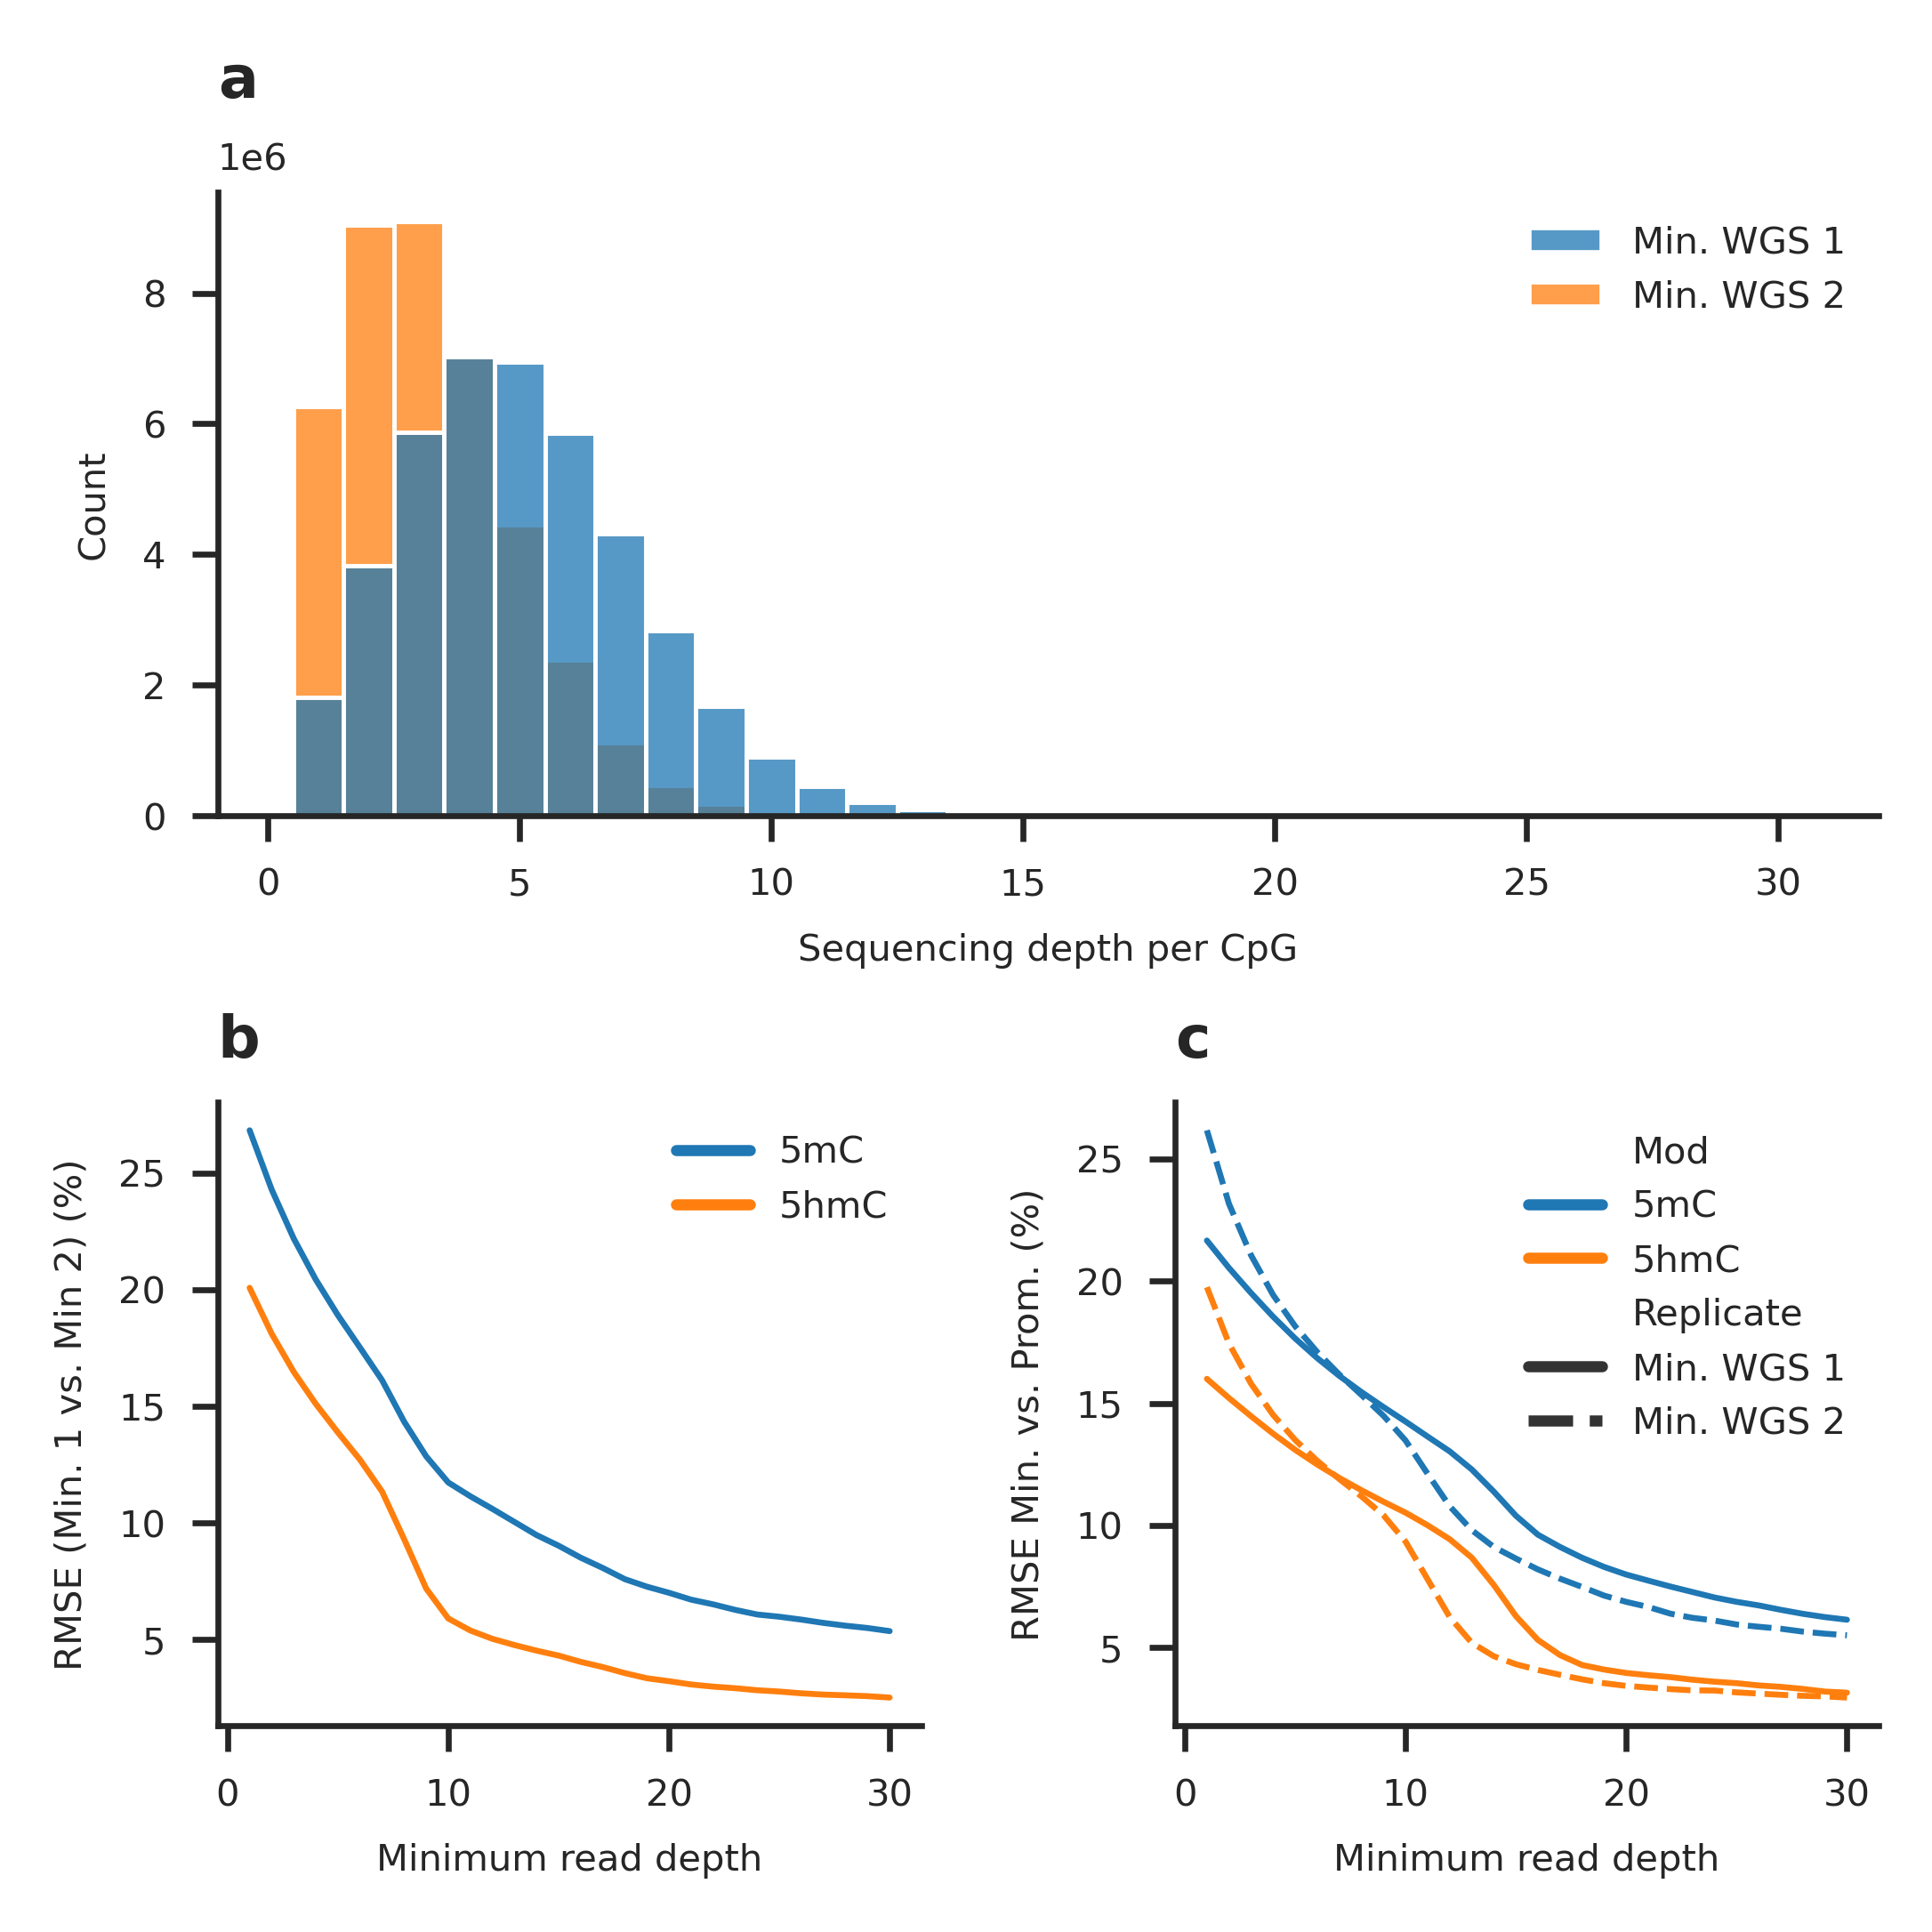

In [78]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
import string

fig =  plt.figure(figsize=(89/25.4, 89/25.4), dpi=600, layout="constrained")

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

mpl.rc('font', size=5)
sns.set_style("ticks")

# Panel 1 #

sns.histplot(mins, x="readCount",
             stat="count", discrete=True, binwidth=1, binrange=(1, 30), 
             hue="Replicate", lw=0.8, alpha=0.75,
             ax=ax1)

ax1.set_xlabel("Sequencing depth per CpG")
sns.move_legend(ax1, "upper right", title=None, frameon=False)

# Panel 2 # 

sns.lineplot(min_rep_comp.melt("Threshold", ["RMSE_5mC", "RMSE_5hmC"], "Modification", "RMSE").replace(["RMSE_5mC", "RMSE_5hmC"], ["5mC", "5hmC"]), 
             x="Threshold", y="RMSE", 
             hue="Modification", lw=0.8,
             ax=ax2)

ax2.set_ylabel("RMSE (Min. 1 vs. Min 2) (%)")
ax2.set_xlabel("Minimum read depth")
ax2.legend(title=None, frameon=False)

# Panel 3 # 

sns.lineplot(all_cpg_depth_df.replace(["Rep1", "Rep2"], ["Min. WGS 1", "Min. WGS 2"]), x="Threshold", y="RMSE", 
             hue="Mod", lw=0.8, style="Replicate", 
             ax=ax3)

ax3.set_ylabel("RMSE Min. vs. Prom. (%)")
ax3.set_xlabel("Minimum read depth")
ax3.legend(frameon=False)

for ax, letter in zip([ax1, ax2, ax3], string.ascii_lowercase[:3]):
    ax.set_title(f"{letter}", loc="left", fontsize=8, fontweight="bold")
    
sns.despine()
# fig.subplots_adjust(wspace=0.4, bottom=.1)
# fig.legend()
fig.show()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/interassay.png", dpi=600)

# Imprinting control region analysis


Note readID: `45d44977-2e22-404a-8683-d07facf254eb` appears to pass through two DMR (Nespas-Gnasxl and Gnas) loci - it is methylated in the Gnas DMR and hypomethylated in the Nespas-Gnasxl DMR. Gnas is paternally expressed (maternally imprinted), and GeneImprint notes that Nespas-Gnasxl is expressed depending on isoform variant. 

Visualise how each set of phased reads looks using a clustermap. Cluster 1 in `phased_reads` is the methylated allele. Cluster 2 is the unmethylated allele. 

## All cluster map SFig. 

__Important__: Bases in CpG-contexts are nominally encoded by their modification state. Bases that are absent from a read are also encoded; without this, it is not possible to include reads that do not cover the entire ICR region, or reads that possess any breaks in CpG modification calls (incl. SNPs, no_calls, indels, etc.). A consequence is that the clustering algorithm will also cluster reads containing _CpG positions that are not present in the read_. Graphically, these sites are masked, and it is useful that reads within a cluster that possess absent positions will tend to appear closer toghther; however, reads that contain too many absent positions (e.g.: reads that very partially overlap the ICR region) may override the clustering of actual modification states - leading to errantly large skewing when counting reads by allele. 

To limit this, two thresholds are included (see: `minimum_read_proportion` and `min_cpg_proportion` in Modkit.py and `geneIterator` below) that respectively remove CpG positions that are not present in at least `minimum_read_proportion` reads, and remove reads that contain fewer than `min_cpg_proportion` CpGs within the ICR. I arrived at the default setting below (0.1, 0.15) through trial and error; however, at ICRs where the differentially methylated region is either substantially shorter than or longer than the typical read length, this may need some tuning. 

In [1]:
def geneIterator(read_table, include_bed, replicate, minimum_read_proportion=.1, min_cpg_proportion=.15):
    read_table.set_include_bed(include_bed)

    dmr_table_list = []
    for dmr in list(read_table.include_bed["Name"]):
        try:
            annotated_table = read_table.select_gene(f"{dmr}").cluster_extract(minimum_read_proportion, min_cpg_proportion)
            annotated_table = annotated_table.assign(gene = dmr)
            annotated_table = annotated_table.assign(rep = replicate)

            dmr_table_list.append(annotated_table)
        except:
            print(f"Failed on {dmr}")
            pass

    return pd.concat(dmr_table_list).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

In [2]:
from ModkitTools import ModkitExtract
import pandas as pd

include_bed_path = "feature_references/dmr/mm39_dmr_coordinates_modified.bed" 

read_table_prom = ModkitExtract("data_tables/data_files/nanopore_prom/dmr_files/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_DMRsOnly_modsCalled.tsv").process_read_table()
read_table_prom.set_include_bed(include_bed_path)

read_table_min1 = ModkitExtract("data_tables/data_files/nanopore_min/cbm1_wgs_26_06_23_mapq60_imprinted.tsv").process_read_table()
read_table_min2 = ModkitExtract("data_tables/data_files/nanopore_min/cbm1_wgs_07_08_23_mapq60_imprinted.tsv").process_read_table()

all_reps = pd.concat([geneIterator(read_table_prom, include_bed_path, "Prom"), 
                      geneIterator(read_table_min1, include_bed_path, "Min. 1"), 
                      geneIterator(read_table_min2, include_bed_path, "Min. 2")])
                      
reads_per_gene = all_reps.groupby(["gene", "read_id", "rep"])["cluster"].value_counts().reset_index(name="count")
reads_per_cluster_df = reads_per_gene.groupby(["gene", "rep"])["cluster"].value_counts().reset_index(name="number_reads")

meth_df, unmeth_df = reads_per_cluster_df.query("cluster == 'Methylated'"), reads_per_cluster_df.query("cluster == 'Unmethylated'")

Failed on Kcnq1ot1
Failed on Rasgrf1


In [3]:
prop = reads_per_cluster_df.pivot(index=["gene", "rep"], columns="cluster", values="number_reads").reset_index().assign(
    proportion_methylated = lambda r: r["Methylated"]/(r["Methylated"]+r["Unmethylated"]),
    proportion_unmethylated = lambda r: r["Unmethylated"]/(r["Methylated"]+r["Unmethylated"])
)
prob_bar_df = prop.melt(["gene", "rep"], ["proportion_methylated", "proportion_unmethylated"], "Allele", "Proportion").replace(["proportion_methylated", "proportion_unmethylated"],
                                                                                                                 ["Methylated", "Unmethylated"])

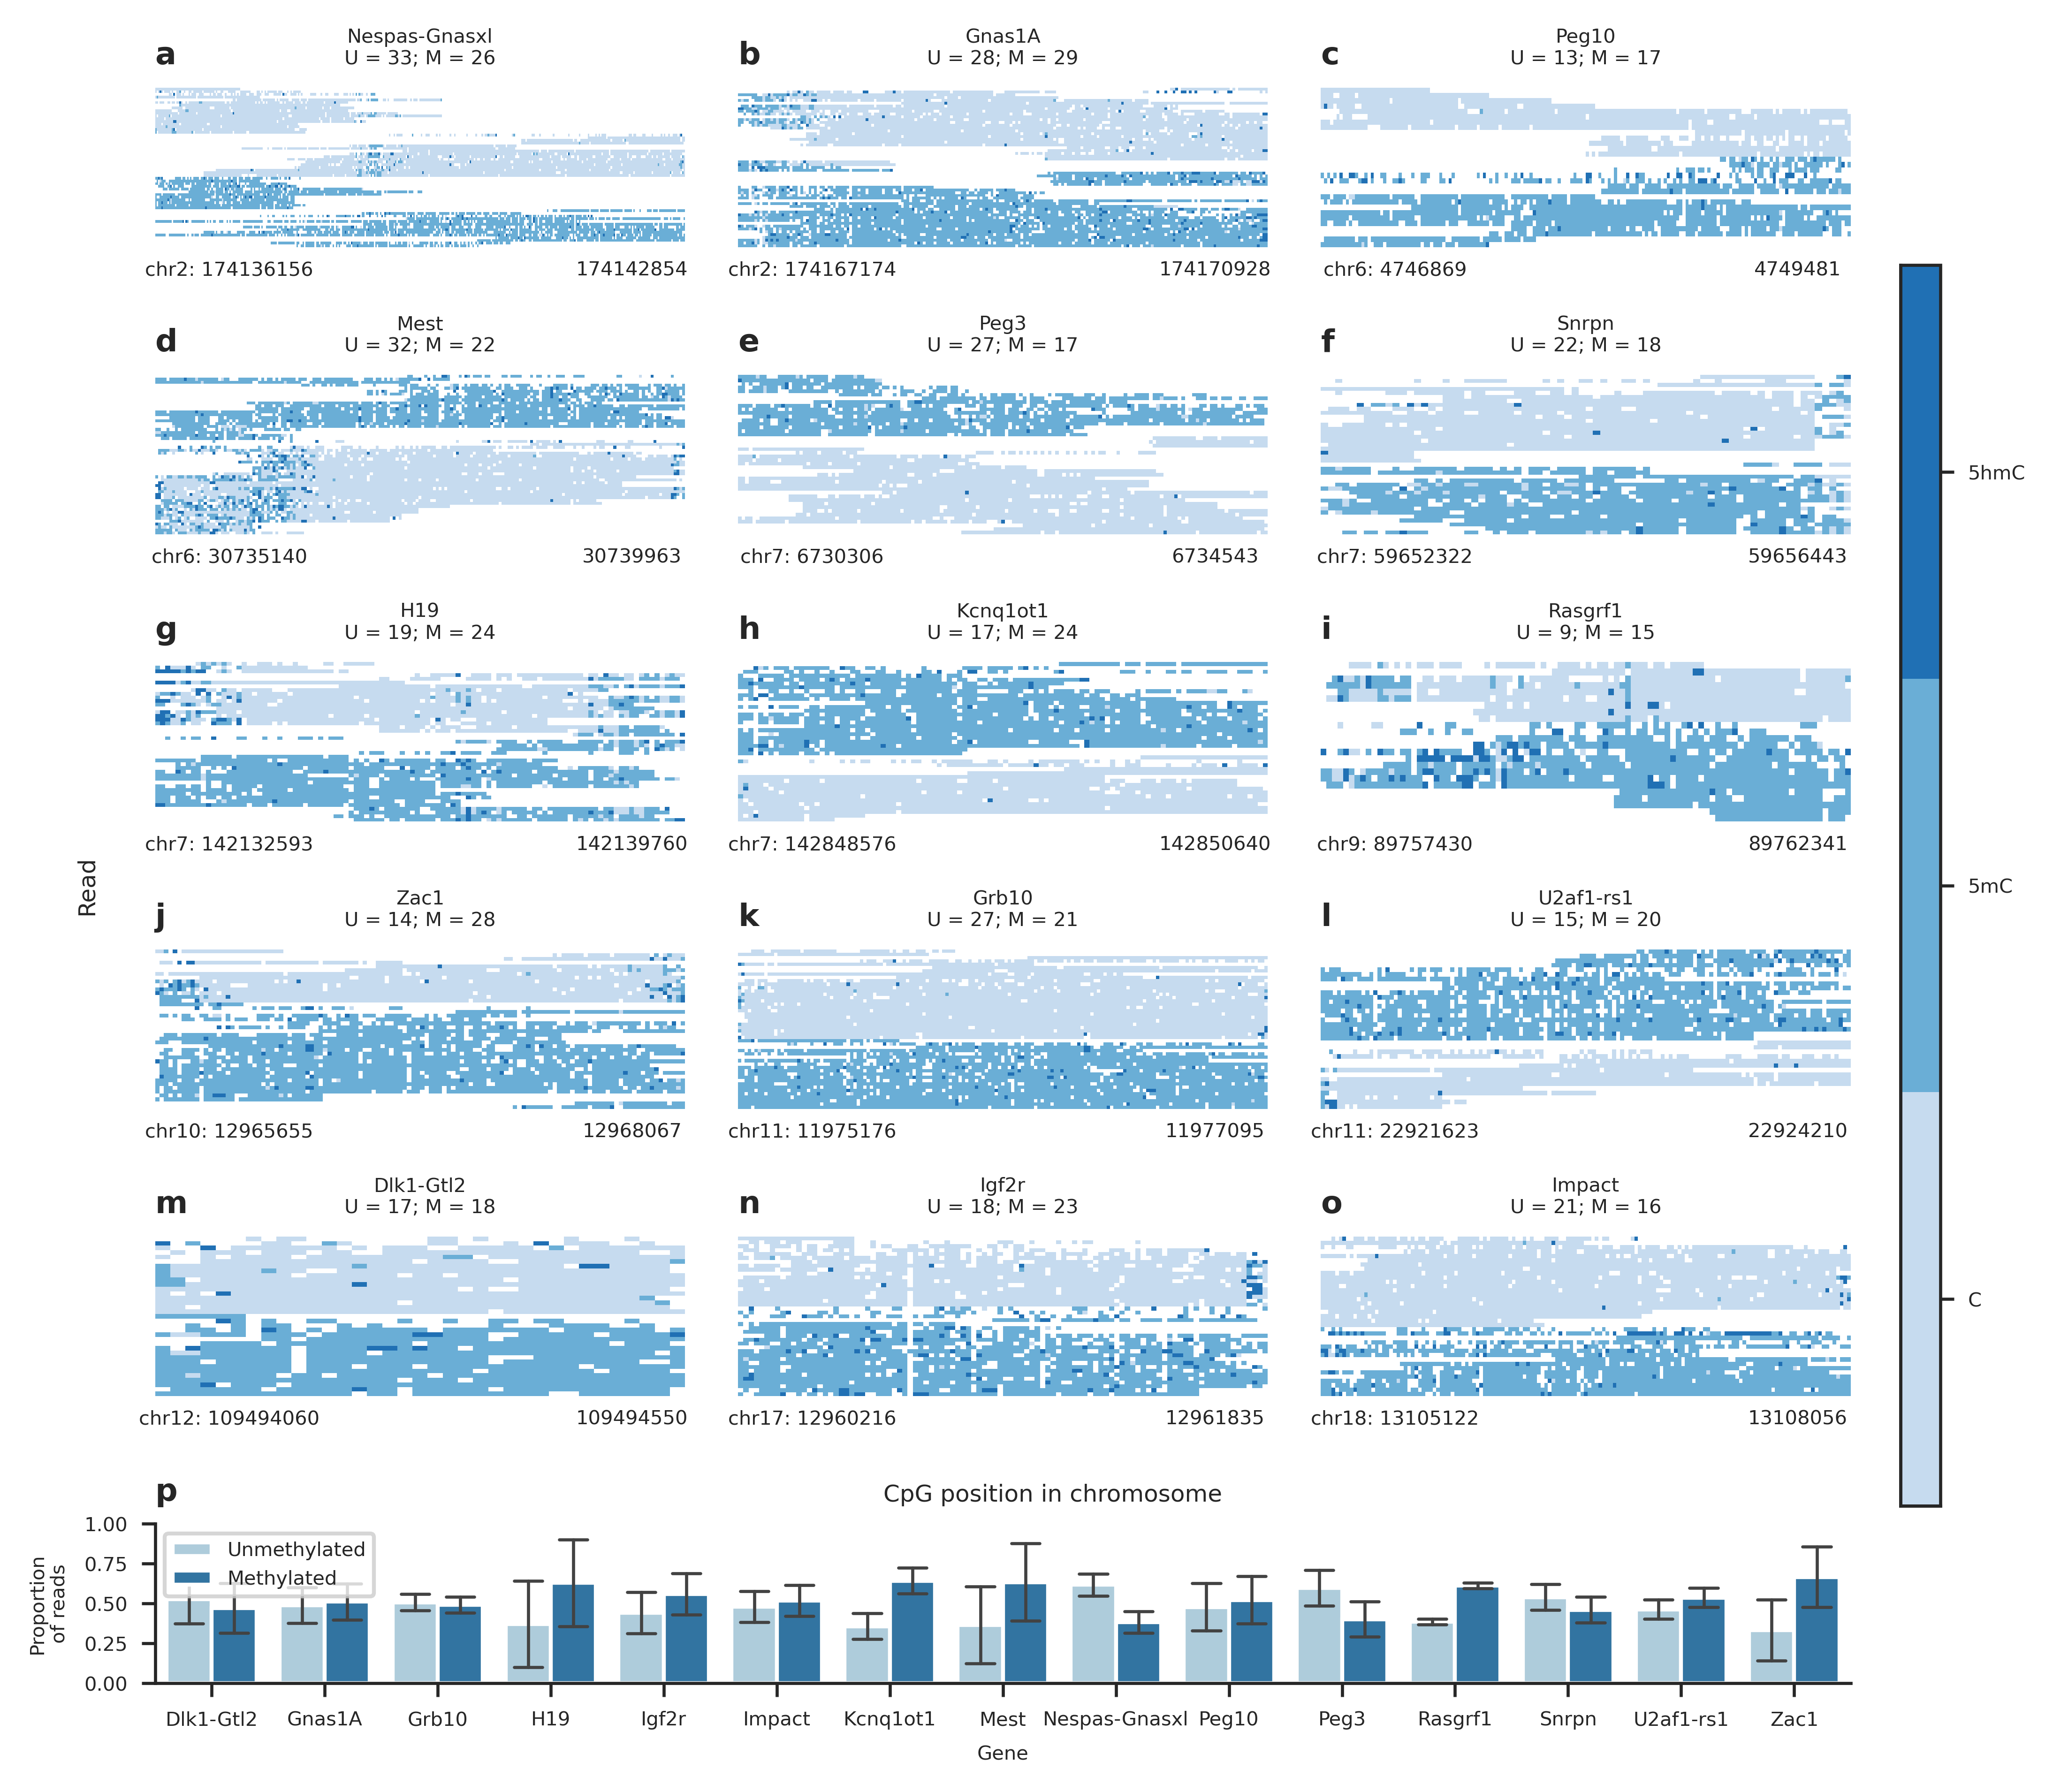

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string
import matplotlib as mpl
import seaborn as sns

mpl.rc('font', size=5)
sns.set_style("ticks")

norm = mpl.colors.Normalize(vmin=0, vmax=2)

fig, axes = plt.subplot_mosaic([["A", "B", "C"],
                                ["D", "E", "F"], 
                                ["G", "H", "I"],
                                ["J", "K", "L"],
                                ["M", "N", "O"],
                                ["P", "P", "P"]], 
                                dpi=600, figsize=(180/25.4, 160/25.4))

cmap = (mpl.colors.ListedColormap(sns.color_palette("Blues", 3)))
norm = mpl.colors.BoundaryNorm([0, 1, 2, 3], cmap.N)

cbar_ax = fig.add_axes([.925, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.minorticks_off()
cbar.set_ticks([.5, 1.5, 2.5], labels=["C", "5mC", "5hmC"])

sns.despine()

for dmr, letter, ax in zip(list(read_table_prom.include_bed["Name"]), list(string.ascii_lowercase), axes.values()):
    try:
        gene_table = read_table_prom.select_gene(f"{dmr}")

        read_counts = gene_table.cluster_extract().groupby(["cluster", "read_id"]).count().reset_index()["cluster"].value_counts()

        gene_table.heatmap(.1, .15, ax=ax)
    except:
        pass
    
    ax.set_title(f"{letter}", loc="left", fontsize=8, fontweight="bold")

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.tick_params("x", pad=0, labelbottom=True, bottom=False)
    sns.despine(ax=ax, bottom=True, left=True)

fig.supylabel("Read", x=.01)
fig.supxlabel("CpG position in chromosome", y=.15)
fig.subplots_adjust(hspace=.8, wspace=.1, bottom=.05, left=.05, top=.95)

sns.barplot(prob_bar_df, x="gene", y="Proportion", 
            hue="Allele", dodge=True, palette="Paired", 
            hue_order=["Unmethylated", "Methylated"],
            errorbar=("sd", 1),
            errwidth=0.8, capsize=0.25,
            ax=axes["P"])


axes["P"].set_title("p", loc="left", fontsize=8, fontweight="bold")
axes["P"].set_xlabel("Gene")
axes["P"].set_ylabel("Proportion\nof reads")
axes["P"].set_ylim(0, 1)

axes["P"].legend(title=None, loc="upper left")

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/all_DMR_clusters.png", 
            dpi=600)

In [5]:
prop.groupby("gene").agg({
    "Methylated" : sum,
    "Unmethylated" : sum
}).reset_index().assign(m_prop = lambda r: r["Methylated"]/(r["Methylated"] + r["Unmethylated"]),
                        u_prop = lambda r: r["Unmethylated"]/(r["Methylated"] + r["Unmethylated"]))

cluster           gene  Methylated  Unmethylated    m_prop    u_prop
0            Dlk1-Gtl2          24            26  0.480000  0.520000
1               Gnas1A          38            37  0.506667  0.493333
2                Grb10          38            43  0.469136  0.530864
3                  H19          41            26  0.611940  0.388060
4                Igf2r          37            27  0.578125  0.421875
5               Impact          26            29  0.472727  0.527273
6             Kcnq1ot1          31            20  0.607843  0.392157
7                 Mest          47            44  0.516484  0.483516
8        Nespas-Gnasxl          36            51  0.413793  0.586207
9                Peg10          31            27  0.534483  0.465517
10                Peg3          33            46  0.417722  0.582278
11             Rasgrf1          18            11  0.620690  0.379310
12               Snrpn          29            35  0.453125  0.546875
13           U2af1-rs1          31            26  0.543860  0.456140
14                Zac1          50            27  0.649351  0.350649

## Main figure

In [5]:
from common import pieData

def proportion(df, mod, round_int=2):
    values, labels = pieData(df, "classification")
    proportion_df = pd.DataFrame(values, labels, columns=["count"])
    proportion_dict = proportion_df.assign(proportion = lambda r: r.div(r.sum())).to_dict()
    
    mod_proportion = proportion_dict["proportion"][mod]
    return round(mod_proportion, round_int)

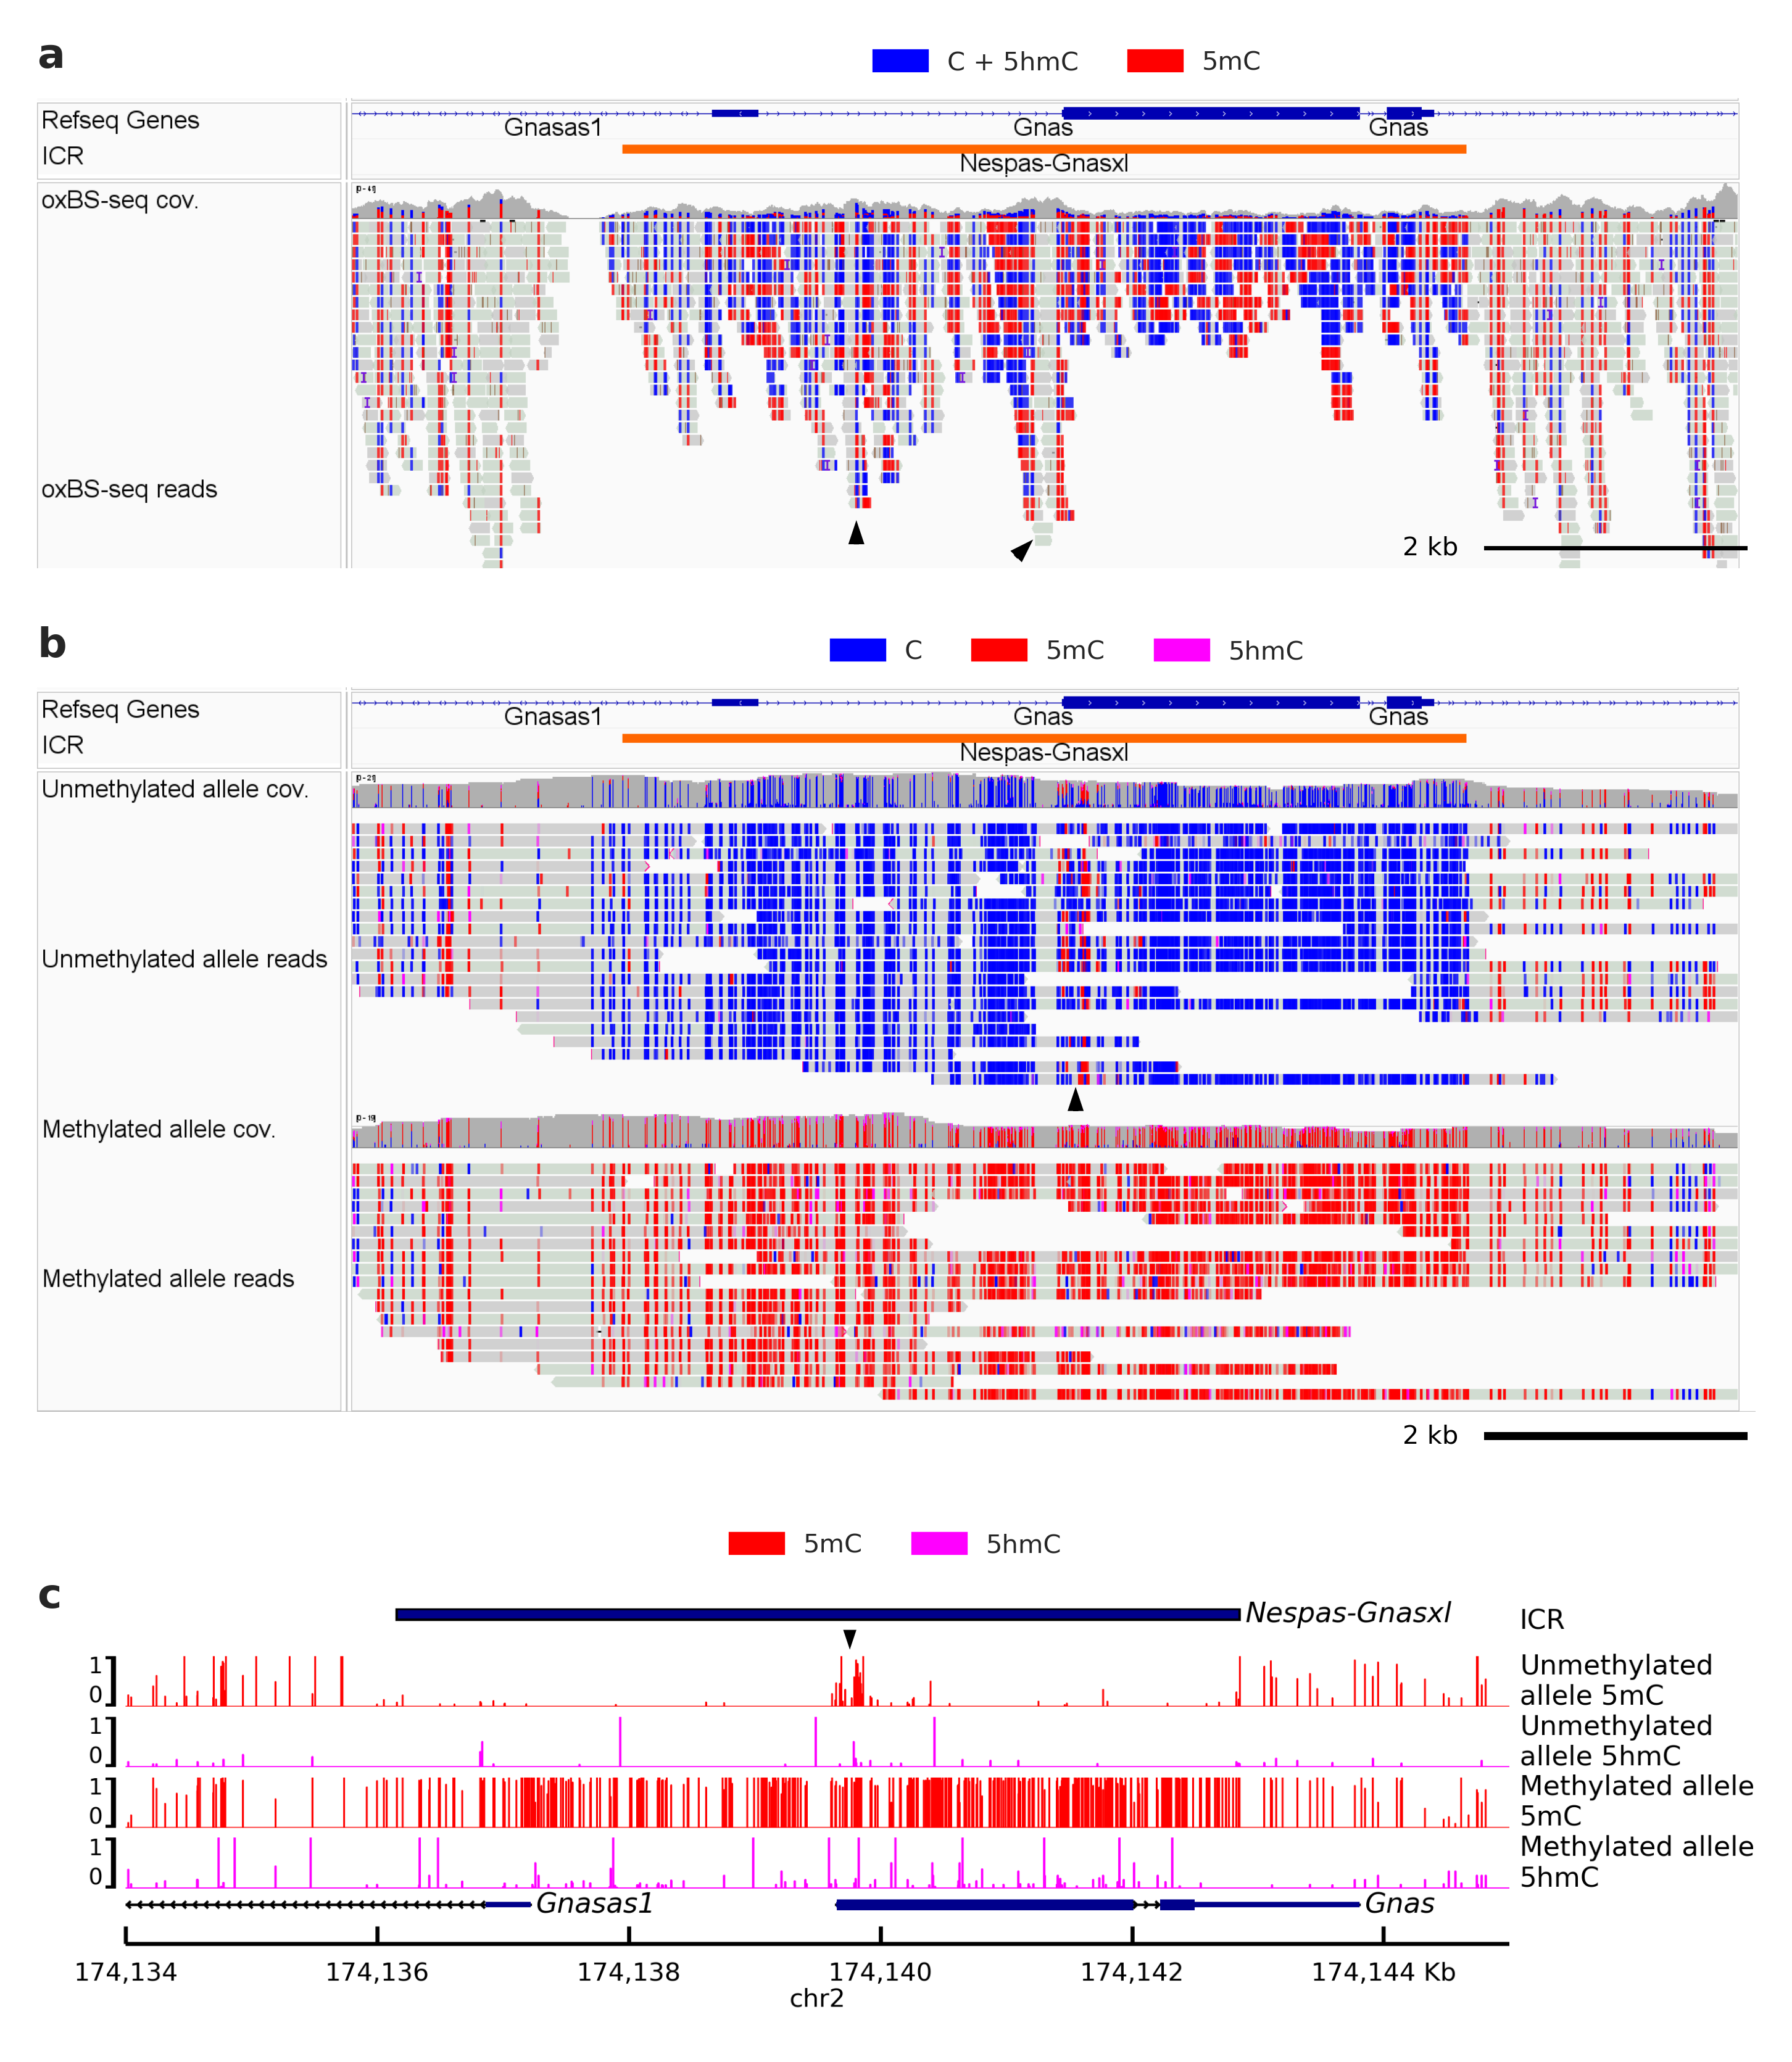

In [17]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.text import OffsetFrom
from PIL import Image
import numpy as np

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 140/25.4), dpi=600, layout="constrained")
gs = GridSpec(3, 1, fig, height_ratios=(1, 2, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])

dim = matplotlib_scalebar.dimension._Dimension("bp")
dim.add_units("kb", 1000)

# Panel 1 # 
im1 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_benchmarks_IGV.png")

w1, h1 = im1.size
scalebar_1 = ScaleBar(11000/(w1-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
im1c = im1.crop((0, 125, w1, 650))

ax1.imshow(im1c)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

l1_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C + 5hmC'),
                   Patch(facecolor='red', edgecolor='r',
                         label='5mC')]   

l1 = ax1.legend(handles=l1_elements, 
                loc="lower center", ncols=3, 
                frameon=False,
                bbox_to_anchor=(.6, 1))   
 
l1.set_in_layout(False)          

sb1 = ax1.add_artist(scalebar_1)
sb1.set_in_layout(False)

a1 = ax1.arrow(x=915, y=495, dx=0, dy=-0.1, color="k", shape="full", head_width=10)
a2 = ax1.arrow(x=1095, y=510, dx=0.5, dy=-.5, color="k", shape="full", head_width=10)

a1.set_in_layout(False)
a2.set_in_layout(False)

# Panel 2 # 
im2 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_IGV.png")

w2, h2 = im2.size
scalebar_2 = ScaleBar(11000/(w2-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
im2c = im2.crop((0, 125, w2, h2+50))

ax2.imshow(im2c)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

l2_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C'),
               Patch(facecolor='red', edgecolor='r',
                         label='5mC'),
               Patch(facecolor="magenta", edgecolor='magenta',
                         label='5hmC')]   

l2 = ax2.legend(handles=l2_elements, 
           loc="lower center", ncols=3, 
           frameon=False,
           bbox_to_anchor=(.6, 1))
l2.set_in_layout(False)

ax2.add_artist(scalebar_2)
ax2.arrow(x=1160, y=470, dx=0, dy=-0.1, color="k", shape="full", head_width=10)

# Panel 3 # 
im3 = Image.open("./data_tables/DMR_analysis/output_images/ICR_pyGenomeTracks_Img.png")
ax3.imshow(im3)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold", y=0.9)
ax3.arrow(x=1340, y=60, dx=0, dy=0, color="k", shape="full", head_width=10)

l3_elements = [Patch(facecolor='red', edgecolor='red',
                         label='5mC'),
               Patch(facecolor='magenta', edgecolor='magenta',
                         label='5hmC')]   
l3 = ax3.legend(handles=l3_elements, 
           loc="upper center", ncols=3, 
           frameon=False,
           bbox_to_anchor=(.5, 1.2))
l3.set_in_layout(False)

# Figure # 

for ax in [ax1, ax2, ax3]:
    plt.grid(False)
    sns.despine(left=True, bottom=True)
    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.grid(False)

# fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=-.175)

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR.png", dpi=600)

In [138]:
proportion(all_reps.query("cluster == 'Methylated'"), "5hmC", 3)

0.054

In [139]:
m_c = proportion(all_reps.query("cluster == 'Unmethylated'"), "5hmC", 3)
m_c

0.019

## Reads per allele

In [40]:
all_calls_by_site = all_reps.groupby(["Chromosome", "Start", "End", "cluster"])["classification"].value_counts().reset_index(name="count")
all_calls_by_site = all_calls_by_site.pivot(index=["Chromosome", "Start", "End", "cluster"], columns="classification", values="count").fillna(0).reset_index()


In [44]:
from scipy import stats

unmethylated_only = all_calls_by_site.query("cluster == 'Unmethylated'")
methylated_only = all_calls_by_site.query("cluster == 'Methylated'")
stats.pearsonr(unmethylated_only["5hmC"], unmethylated_only["5mC"])

PearsonRResult(statistic=0.492304783502957, pvalue=6.185085282788988e-277)

In [45]:
methylated_only.corr()

/tmp/ipykernel_679707/2749388080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  methylated_only.corr()


classification     Start       End      5hmC       5mC         C
classification                                                  
Start           1.000000  1.000000 -0.079740 -0.088295  0.124421
End             1.000000  1.000000 -0.079740 -0.088295  0.124421
5hmC           -0.079740 -0.079740  1.000000  0.313772 -0.021669
5mC            -0.088295 -0.088295  0.313772  1.000000  0.023419
C               0.124421  0.124421 -0.021669  0.023419  1.000000

# hMeDIP analysis using MACS2

In [110]:
import pandas as pd

macs_2_bpeaks = pd.read_csv("../../data/cbm1_ip/macs2/all_c/broad/NA_peaks.xls", sep="\t", skiprows=29, header=1)
macs_2_npeaks = pd.read_csv("../../data/cbm1_ip/macs2/all_c/NA_peaks.xls", sep="\t", skiprows=28, header=1)

macs_2_bpeaks = macs_2_bpeaks.assign(PeakType = "Broad")
macs_2_npeaks = macs_2_npeaks.assign(PeakType = "Narrow")

all_peaks = pd.concat([macs_2_bpeaks, macs_2_npeaks])

### Feature annotation 

In [111]:
import pyranges as pr 
import numpy as np
import FeatureReferences
from MultisiteTools import CpGRange
import warnings
from common import *

def annotateFeatures(table, suffix):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        if type(table) == pr.PyRanges:
            annotated_table = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(table, how="right", 
                                                                            strandedness=False, apply_strand_suffix=False, 
                                                                            report_overlap=True, suffix=f"_{suffix}")
        else: 
            pyrange = pr.PyRanges(table)
            annotated_table = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(pyrange, how="right", 
                                                                            strandedness=False, apply_strand_suffix=False, 
                                                                            report_overlap=True, suffix=f"_{suffix}")
            
    annotated_table = annotated_table.as_df().replace([-1, "-1", "3UTR", "5UTR", "TSS"], ["Intergenic", "Intergenic", "Exon", "Exon", "Promoter"])

    return annotated_table

@asPyRangesDecorator
def chromSizePr():
    return loadChromSize()

def getWGStiles(tile_size=1000):
    prom_comp_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

    # renaming columns for compatability with PyRanges
    prom_comp_data = asPyRanges(prom_comp_data).as_df()
    prom_comp_pr = CpGRange(prom_comp_data)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        tiles = pr.PyRanges(prom_comp_pr.group_by_tile(tile_size).enrichment_over_mean(native=False).df)
    
    return tiles

At this point - selecting peaks with a q-value < 0.001 (-log10(X)=3) that are *not* present in the ENCODE Blacklist. Blacklist is obtained from Amemiya *et al.* (2019). Coordinates lifted over to mm39 from mm10. 

In [112]:
all_peaks = all_peaks.rename(columns={"-log10(qvalue)" : "QVal"})
annotated_peaks = annotateFeatures(all_peaks.query("QVal >= 3").rename(columns=
                                                    {
                                                        "chr" : "Chromosome", 
                                                        "start" : "Start",
                                                        "end" : "End"
                                                    }
                                                        ), "Peak")

annotated_peaks_grouped = annotated_peaks.sort_values("Overlap", ascending=False).groupby(
    ["Chromosome", "Start_Peak", "End_Peak", "PeakType"]).head(1).replace(
    {
        "-1" : "Intergenic",
        "3UTR" : "Exon",
        "5UTR" : "Exon"
    }
    )

# removes peaks that are present in the ENCODE Blacklist. 
blacklist = pr.read_bed("data_tables/blacklist/mm39-blacklist.v2_adj.bed")
select_peaks_as_pr = (pr.PyRanges(annotated_peaks_grouped[["Chromosome", "Start_Peak", "End_Peak", "Strand", "fold_enrichment", "QVal", "feature_type", "PeakType"]]
                                 .rename(columns={"Start_Peak" : "Start", "End_Peak" : "End"}))
                                 .intersect(blacklist, invert=True))

How many broad/narrow peaks after filtering? 

In [113]:
select_peaks_as_pr.as_df()["PeakType"].value_counts()

Narrow    5655
Broad      468
Name: PeakType, dtype: int64

In [114]:
wgs_tiles = getWGStiles(525)

annotated_genome = annotateFeatures(wgs_tiles, "Window")

Changing colnames to be PyRanges compatible...
Done
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


### Feature barplot data 

In [115]:
genome_values, genome_labels = pieData(annotated_genome, "feature_type")
peak_values, peak_labels = pieData(select_peaks_as_pr.as_df(), "feature_type")

genome = pd.DataFrame(genome_values, genome_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))
peaks = pd.DataFrame(peak_values, peak_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))

comp = pd.Series(np.log2(peaks["proportion"]/genome["proportion"]))
    

Significant difference in overall feature composition. 

In [116]:
f_exp = np.array(genome["proportion"].sort_index())
n_exp = f_exp*peaks["count"].sum()
n_obs = np.array(peaks["count"].sort_index())

stats.chisquare(n_obs, n_exp)

Power_divergenceResult(statistic=9849.403537661117, pvalue=0.0)

In [117]:
n_exp = np.array([genome["proportion"]["Promoter"] * peaks["count"].sum(), 
                  genome["proportion"][["Intron", "Exon", "Intergenic"]].sum() * peaks["count"].sum()])

n_obs = np.array([peaks["count"]["Promoter"], peaks["count"][["Intron", "Exon", "Intergenic"]].sum()])

stats.chisquare(n_obs, n_exp)

Power_divergenceResult(statistic=234.2480922854186, pvalue=7.062207612913018e-53)

In [118]:
n_exp = np.array([genome["proportion"][["Intron", "Exon"]].sum() * peaks["count"].sum(), 
                  genome["proportion"][["Promoter", "Intergenic"]].sum() * peaks["count"].sum()])

n_obs = np.array([peaks["count"][["Intron", "Exon"]].sum(), peaks["count"][["Promoter", "Intergenic"]].sum()])

stats.chisquare(n_obs, n_exp)

Power_divergenceResult(statistic=9281.701969157439, pvalue=0.0)

### C-Call enrichment data

In [119]:
from common import *
import numpy as np

def callStats(df):
    calls = df.agg({
        "N_C" : sum, 
        "N_5mC" : sum, 
        "N_5hmC" : sum
        })
    
    call_stats = pd.DataFrame(calls, columns=["count"])
    call_stats = call_stats.assign(proportion = lambda r: r.div(r.sum()))
    
    return call_stats

In [120]:
# replicate info included for downstream 
pilot = readModkit("data_tables/data_files/nanopore_hmedip/pilot_modified_bases_modkit.bed", 1, False, True).assign(replicate = "Pilot")
rep1 = readModkit("data_tables/data_files/nanopore_hmedip/cbm1_ip_rep1_modbases_mapq60.bed", 1, False, True).assign(replicate = "hMeDIP 1")
rep2 = readModkit("data_tables/data_files/nanopore_hmedip/cbm1_ip_rep2_23_05_09_mapq60.bed", 1, False, True).assign(replicate = "hMeDIP 2")

all_reps = pd.concat([pilot, rep1, rep2])
# specifically select CpG sites present in the filtered peaks
all_reps_filtered = pr.PyRanges(all_reps).intersect(select_peaks_as_pr).as_df()

In [121]:
all_reps_position_merged = all_reps_filtered.groupby(["Chromosome", "Start", "End", "Strand"], observed=True).agg(
    readCount = ("readCount", np.sum),
    N_C = ("N_C", np.sum),
    N_5mC = ("N_mC", np.sum),
    N_5hmC = ("N_hmC", np.sum)
).assign(
    percentMeth_5mC = lambda r: r["N_5mC"]/r["readCount"],
    percentMeth_5hmC = lambda r: r["N_5hmC"]/r["readCount"]
).reset_index()


In [122]:
if not "wgs_all_calls" in locals().keys():
    wgs_all_calls = readModkit("data_tables/data_files/nanopore_prom/prom_R10.4.1_E8.2_WGS_0.3.2_sorted_mapq60_modkit.bed", 1, False, True)
    
wgs_all_calls = wgs_all_calls.rename(columns={"N_mC" : "N_5mC", "N_hmC" : "N_5hmC"})

In [123]:
bar_comp = pd.Series(((callStats(all_reps_position_merged)["proportion"] - callStats(wgs_all_calls)["proportion"])/callStats(wgs_all_calls)["proportion"])*100)
bar_comp.index = ["C", "5mC", "5hmC"]

In [124]:
callStats(wgs_all_calls)

count  proportion
N_C     139685454.0    0.240182
N_5mC   393634772.0    0.676836
N_5hmC   48260580.0    0.082982

In [125]:
callStats(all_reps_position_merged)

count  proportion
N_C      97916.0    0.299415
N_5mC   122488.0    0.374554
N_5hmC  106620.0    0.326031

In [126]:
n_exp = np.array([callStats(wgs_all_calls)["proportion"]["N_5hmC"] * callStats(all_reps_position_merged)["count"].sum(), 
                  callStats(wgs_all_calls)["proportion"][["N_C", "N_5mC"]].sum() * callStats(all_reps_position_merged)["count"].sum()])
n_obs = np.array([callStats(all_reps_position_merged)["count"]["N_5hmC"], callStats(all_reps_position_merged)["count"][["N_C", "N_5mC"]].sum()])

stats.chisquare(n_obs, n_exp)

Power_divergenceResult(statistic=253868.15900781532, pvalue=0.0)

In [127]:
n_exp = np.array([callStats(wgs_all_calls)["proportion"]["N_5mC"] * callStats(all_reps_position_merged)["count"].sum(), 
                  callStats(wgs_all_calls)["proportion"][["N_C", "N_5hmC"]].sum() * callStats(all_reps_position_merged)["count"].sum()])
n_obs = np.array([callStats(all_reps_position_merged)["count"]["N_5mC"], callStats(all_reps_position_merged)["count"][["N_C", "N_5hmC"]].sum()])

stats.chisquare(n_obs, n_exp)

Power_divergenceResult(statistic=136615.10957948153, pvalue=0.0)

### Peak context histogram
Note: Different thresholds on CpG depth for TAB mean different numbers of CpGs overall.

In [128]:
prom_comp_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

# renaming columns for compatability with PyRanges
prom_comp_data = asPyRanges(prom_comp_data).as_df()
prom_comp_pr = CpGRange(prom_comp_data)

Changing colnames to be PyRanges compatible...
Done


In [129]:
import warnings 
import pyranges as pr

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(525).enrichment_over_mean(native=False).df)

# Takes the peaks with q-value < 0.001 and matches them to genomic windows from WGS
tiled_peak_df = select_peaks_as_pr.join(wgs_tiles, suffix="_Tile", report_overlap=True).as_df()

# groupby()...head() is used to select the tile with the highest degree of overlap with the peak
tiled_peak_df = tiled_peak_df.sort_values("Overlap",ascending=False).groupby(["Chromosome", "Start", "End"]).head(1)

Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


In [130]:
len(tiled_peak_df.query("log2enrichment_5hmC_TAB > 0"))/len(tiled_peak_df)

0.9174871996849153

### Figure

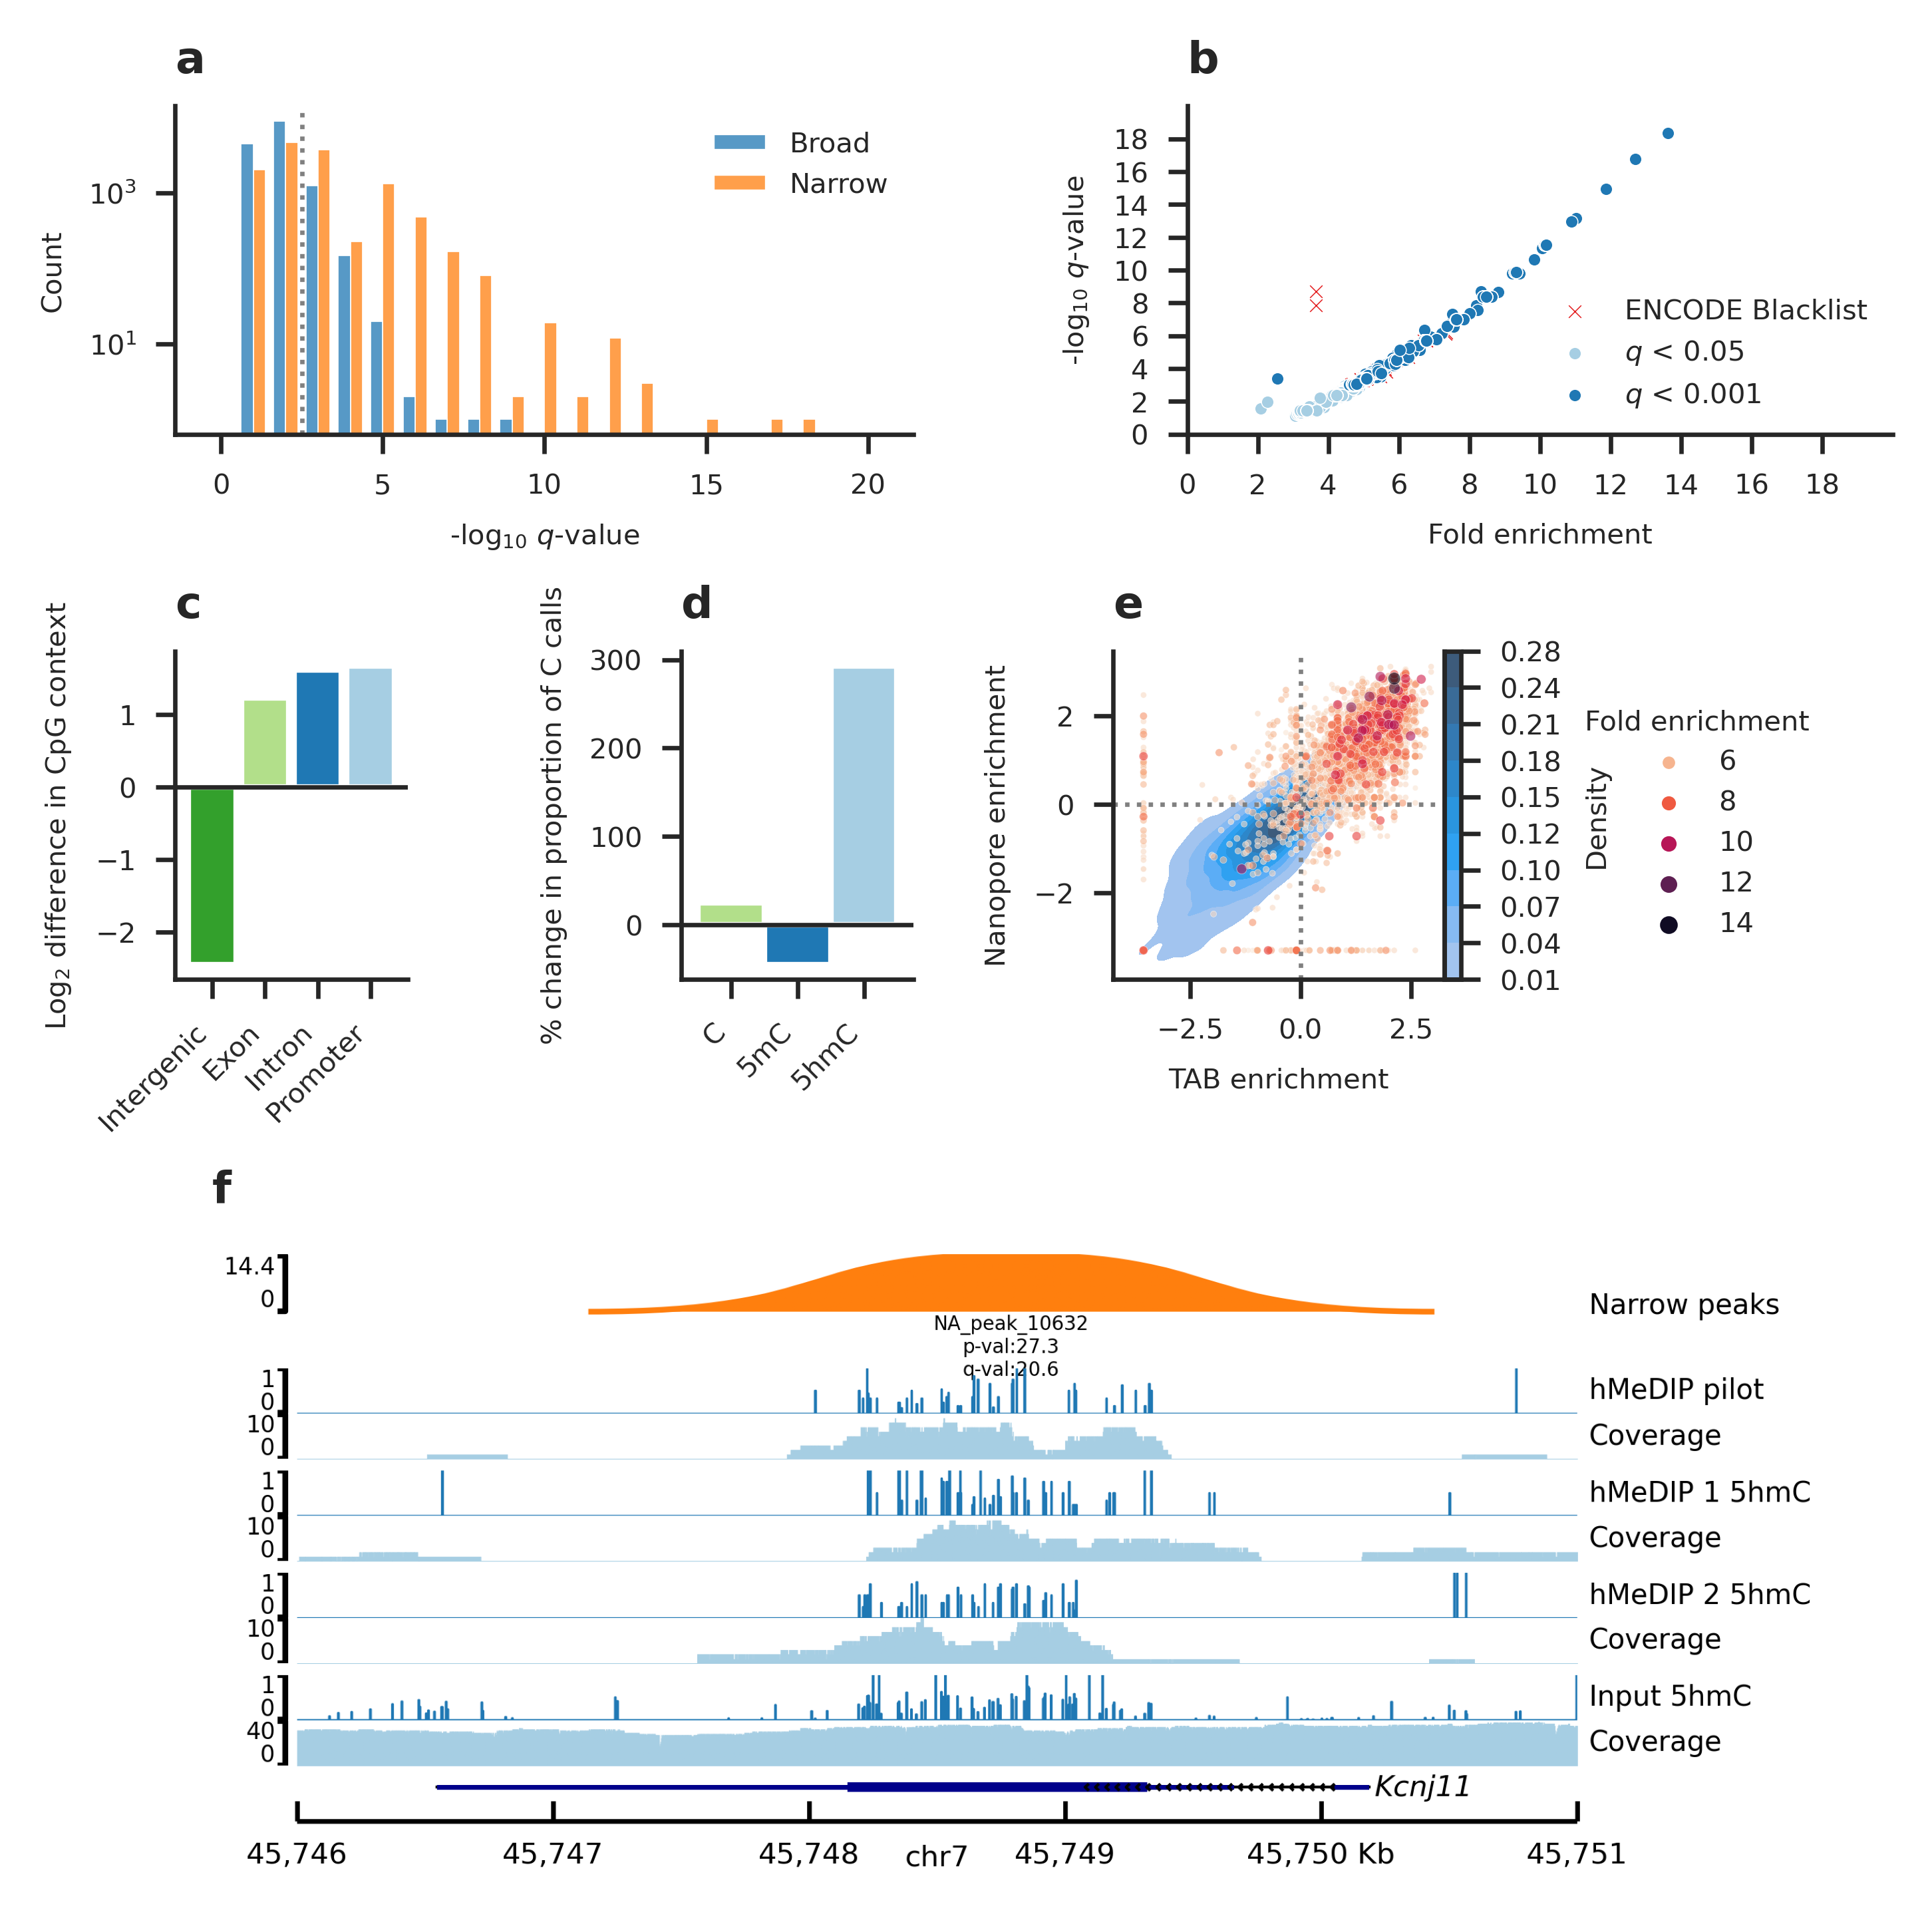

In [131]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(120/25.4, 120/25.4), dpi=600, layout="constrained")
sns.set_style("ticks")
mpl.rc('font', size=5)

gs = GridSpec(3, 4, fig, height_ratios=(1, 1, 2))

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 1:])
ax6 = fig.add_subplot(gs[2, :])

# Panel 1 # 

sns.histplot(all_peaks, x="QVal",
             hue="PeakType", multiple="dodge",
             discrete=True, binrange=(0, 20),
             log_scale=(False, True), shrink=0.75,
             ax=ax1)

ax1.set_xlabel(r"-log$_{10}$ $\it{q}$-value")
ax1.axvline(2.5, ls=":", c="grey", lw=0.8)
sns.move_legend(ax1, "upper right", frameon=False, title=None)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 #

sns.scatterplot((pr.PyRanges(all_peaks.rename(columns={"chr" : "Chromosome", "start" : "Start", "end" : "End"}))
                 .intersect(blacklist)
                 .as_df()
                 .query("QVal >= 3")), 
                x="fold_enrichment", y="QVal", 
                marker="x", 
                label="ENCODE Blacklist",
                s=5,
                color=sns.color_palette("Paired", 6)[5],
                ax=ax2)

sns.scatterplot(all_peaks.query("QVal < 3"), 
                x="fold_enrichment", y="QVal",
                label=r"$\it{q}$ < 0.05",
                s=5,
                color=sns.color_palette("Paired", 2)[0],
                ax=ax2)

sns.scatterplot(select_peaks_as_pr.as_df(), 
                x="fold_enrichment", y="QVal",
                label=r"$\it{q}$ < 0.001",
                s=5,
                color=sns.color_palette("Paired", 2)[1],
                ax=ax2)

ax2.set_xlim(0, 20)
ax2.set_xticks(range(0, 20, 2))
ax2.set_yticks(range(0, 20, 2))

ax2.set_ylim(0, 20)
ax2.set_ylabel(r"-log$_{10}$ $\it{q}$-value")
ax2.set_xlabel("Fold enrichment")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

sns.move_legend(ax2, "lower right", frameon=False, title=None)


# Panel 3 # 

comp.sort_values().plot.bar(ax=ax3, 
                            width=.9,
                            color=sns.color_palette("Paired", 4)[::-1])
ax3.axhline(0, c=(0.15, 0.15, 0.15, 1.0), lw=0.8)
ax3.set_ylabel(f"Log$_{2}$ difference in CpG context")
ax3.tick_params(axis="x", which="both", labelrotation=45)
ax3.set_xticklabels(ax3.get_xticklabels(), ha="right")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 3 # 

ax4.axhline(0, c=(0.15, 0.15, 0.15, 1.0), lw=0.8)
bar_comp.plot.bar(color=sns.color_palette("Paired", 3)[::-1], 
                  width=1,
                  ax=ax4)
ax4.set_ylabel(f"% change in proportion of C calls")
ax4.tick_params(axis="x", which="both", labelrotation=45)
ax4.set_xticklabels(ax4.get_xticklabels(), ha="right")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

# Panel 4 # 
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("right", size="5%", pad=0)

sns.kdeplot(wgs_tiles.as_df().query("CpG_count >= 15"), 
            x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
            fill=True, 
            cbar=True, cbar_ax=cax5, 
            cbar_kws={"format" : "%2.2f",
                      "label" : "Density"},
            ax=ax5)

sns.scatterplot(tiled_peak_df.sort_values("fold_enrichment"), 
                x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore",
                hue="fold_enrichment", palette="rocket_r", 
                size="fold_enrichment", sizes=(1, 5),
                alpha=0.6,
                ax=ax5)

ax5leg = ax5.legend(frameon=False, title="Fold enrichment", 
                    bbox_to_anchor=(1.35, .9))
ax5leg.set_in_layout(False)

ax5.axvline(0, ls=":", c="grey", lw=0.8)
ax5.axhline(0, ls=":", c="grey", lw=0.8)

ax5.set_title("e", loc="left", fontsize=8, fontweight="bold")
ax5.set_xlabel("TAB enrichment")
ax5.set_ylabel("Nanopore enrichment")
ax5.set_aspect("equal")
               
# Panel 6 # 

im6 = plt.imread("./data_tables/hmedip/rep_image/output_img/hmedip_repImg1.png")
ax6.imshow(im6)
ax6.grid(False)
ax6.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
ax6.set_title("f", loc="left", fontsize=8, fontweight="bold")

# Figure # 

sns.despine()
sns.despine(ax=ax6, bottom=True, left=True, right=True)

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP.png", dpi=600)

### Additional working out
How CpG dense? 

In [132]:
mouse_genome_overlaps = pr.get_sequence(select_peaks_as_pr, "../../data/reference_genomes/mm39/mm39.fa")

In [133]:
densities = []
for sequence in mouse_genome_overlaps: 
    cpg_count = sequence.upper().count("CG")
    total_length = len(sequence)
    density = (cpg_count/total_length)*100 
    densities.append(density)

# previously calculated from fasta 
genome_cg_density = 0.48245101843420024
(sum(densities)/len(densities))/genome_cg_density

4.644763877721645

Average peak 5hmC content

In [134]:
all_reps_filtered_keep_peaks = (pr.PyRanges(all_reps).join(select_peaks_as_pr, suffix="_Peak").as_df()
                                .groupby(["Start_Peak", "End_Peak"])
                                .agg(
                                    N_hmC = ("N_hmC", sum),
                                    N_mC = ("N_mC", sum),
                                    N_C = ("N_C", sum),
                                    call_count = ("readCount", sum)
                                )
                                .reset_index())
all_reps_filtered_keep_peaks = all_reps_filtered_keep_peaks.assign(avg_percentMeth_5hmC = lambda r: (r["N_hmC"]/r["call_count"])*100)

In [135]:
tiled_peak_df["percentMeth_5hmC_Nanopore"].mean()


28.070953366746906

In [136]:
all_reps_filtered_keep_peaks["avg_percentMeth_5hmC"].mean()

35.970425459109386

In [137]:
wgs_tiles.as_df()["percentMeth_5hmC_TAB"].mean()

10.356538254834513

## hMeDIP-seq SFig

Requires `pilot`, `rep1`, `rep2` and `select_peaks_as_pr` from above. 

### Venn Diagram

In [138]:
pilot_pr = pr.read_bam("../../data/cbm1_ip/cbm1_ip_13_07_23/alignments/cbm1_ip_13_07_23_basecalls_sorted_mapq60.bam")
rep1_pr = pr.read_bam("../../data/cbm1_ip/rep1_23_16_08/basecalls/cbm1_ip_rep1_23_16_08_sorted_mapq60.bam")
rep2_pr = pr.read_bam("../../data/cbm1_ip/rep2_23_05_09/basecalls/cbm1_ip_rep2_23_05_09_sorted_q60.bam")

In [139]:
pie_values, pie_labels = pieData(select_peaks_as_pr.as_df(), "feature_type")

In [140]:
from matplotlib_venn import venn3
def VennDiagrammer3Ways(r0, r1, r2, ax=None):
    r0_only = len(r0.overlap(r1, invert=True, strandedness=False).overlap(r2, invert=True, strandedness=False))
    r1_only = len(r1.overlap(r2, invert=True, strandedness=False).overlap(r0, invert=True, strandedness=False))
    r2_only = len(r2.overlap(r0, invert=True, strandedness=False).overlap(r1, invert=True, strandedness=False))

    r01 = len(r0.overlap(r1).overlap(r2, invert=True, strandedness=False))
    r02 = len(r0.overlap(r2).overlap(r1, invert=True, strandedness=False))
    r12 = len(r1.overlap(r2).overlap(r0, invert=True, strandedness=False))

    r012 = len(r0.overlap(r1, strandedness=False).overlap(r2, strandedness=False))
    
    total = sum([r0_only, r1_only, r2_only, r01, r02, r12, r012])

    if not ax:
        fig, ax = plt.subplots()

    venn = venn3(
            {
        "001" : r0_only,
        "010" : r2_only,
        "100" : r1_only,
        "011" : r12, 
        "110" : r02,
        "101" : r01,
        "111" : r012
        },
        set_labels=["IgG purified\nα-5hmC 1", "IgG purified\nα-5hmC 2", "Whole serum\nα-5hmC "],
        set_colors=[sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1], sns.color_palette("Paired", 3)[0]],
        alpha=1,
        subset_label_formatter=lambda x: f"{(x/total):1.1%}",
        ax=ax)
    
    return venn

In [141]:
from matplotlib_venn import *
def VennDiagrammer2Ways(r1, r2, ax=None):
    r1_only = len(r1.overlap(r2, invert=True, strandedness=False))
    r2_only = len(r2.overlap(r1, invert=True, strandedness=False))

    r12 = len(r1.overlap(r2))
    total = sum([r1_only, r2_only, r12])

    if not ax:
        fig, ax = plt.subplots()

    venn = venn2({
        "10" : r1_only,
        "01" : r2_only,
        "11" : r12
    },
        set_labels=["hMeDIP 1", "hMeDIP 2"],
        set_colors=[sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1]],
        alpha=1,
        subset_label_formatter=lambda x: f"{(x/total):1.1%}",
        ax=ax)
    
    return venn

In [142]:
import pyranges as pr

def prPeakDepth(pyrange, min_peakDepth):
    df = pyrange.as_df() 
    df = df.query(f"Name >= {min_peakDepth}")
    return pr.PyRanges(df)
    

### Pie chart of feature annotations

In [143]:
from common import pieData
pie_values, pie_labels = pieData(select_peaks_as_pr.as_df(), "feature_type")

### Peak density vs. WGS KDE Plot

In [144]:
def splitPeaks(df, peaks):
    keep_peaktype = (pr.PyRanges(df).join(peaks, suffix="_Peak")
                     .as_df()
                     .groupby(["Start_Peak", "End_Peak"])
                     .agg(
                         N_hmC = ("N_hmC", sum),
                         N_mC = ("N_mC", sum),
                         N_C = ("N_C", sum),
                         call_count = ("readCount", sum)
                         )
                     .reset_index())
    keep_peaktype = keep_peaktype.assign(avg_percentMeth_5hmC = lambda r: (r["N_hmC"]/r["call_count"])*100)
    return keep_peaktype

def splitPeakTypes(df, peaks, peaktype):
    keep_peaktype = (pr.PyRanges(df).join(peaks, suffix="_Peak")
                     .as_df()
                     .query(f"PeakType == '{peaktype}'")
                     .groupby(["Start_Peak", "End_Peak"])
                     .agg(
                         N_hmC = ("N_hmC", sum),
                         N_mC = ("N_mC", sum),
                         N_C = ("N_C", sum),
                         call_count = ("readCount", sum)
                         )
                     .reset_index())
    keep_peaktype = keep_peaktype.assign(avg_percentMeth_5hmC = lambda r: (r["N_hmC"]/r["call_count"])*100)
    return keep_peaktype

The average 5hmC beta-value is higher over 1kb window in the hMeDIP-seq than both the WGS average _and_ those same regions in nanopore WGS. 

In [145]:
all_kde = pd.concat([splitPeaks(all_reps, select_peaks_as_pr).rename(columns={"avg_percentMeth_5hmC" : "percentMeth_5hmC_Nanopore"}).assign(data_type = "Peaks"), 
                     wgs_tiles.as_df().assign(data_type = "All WGS"), tiled_peak_df.assign(data_type = "WGS overlapping peak")])

### Figure

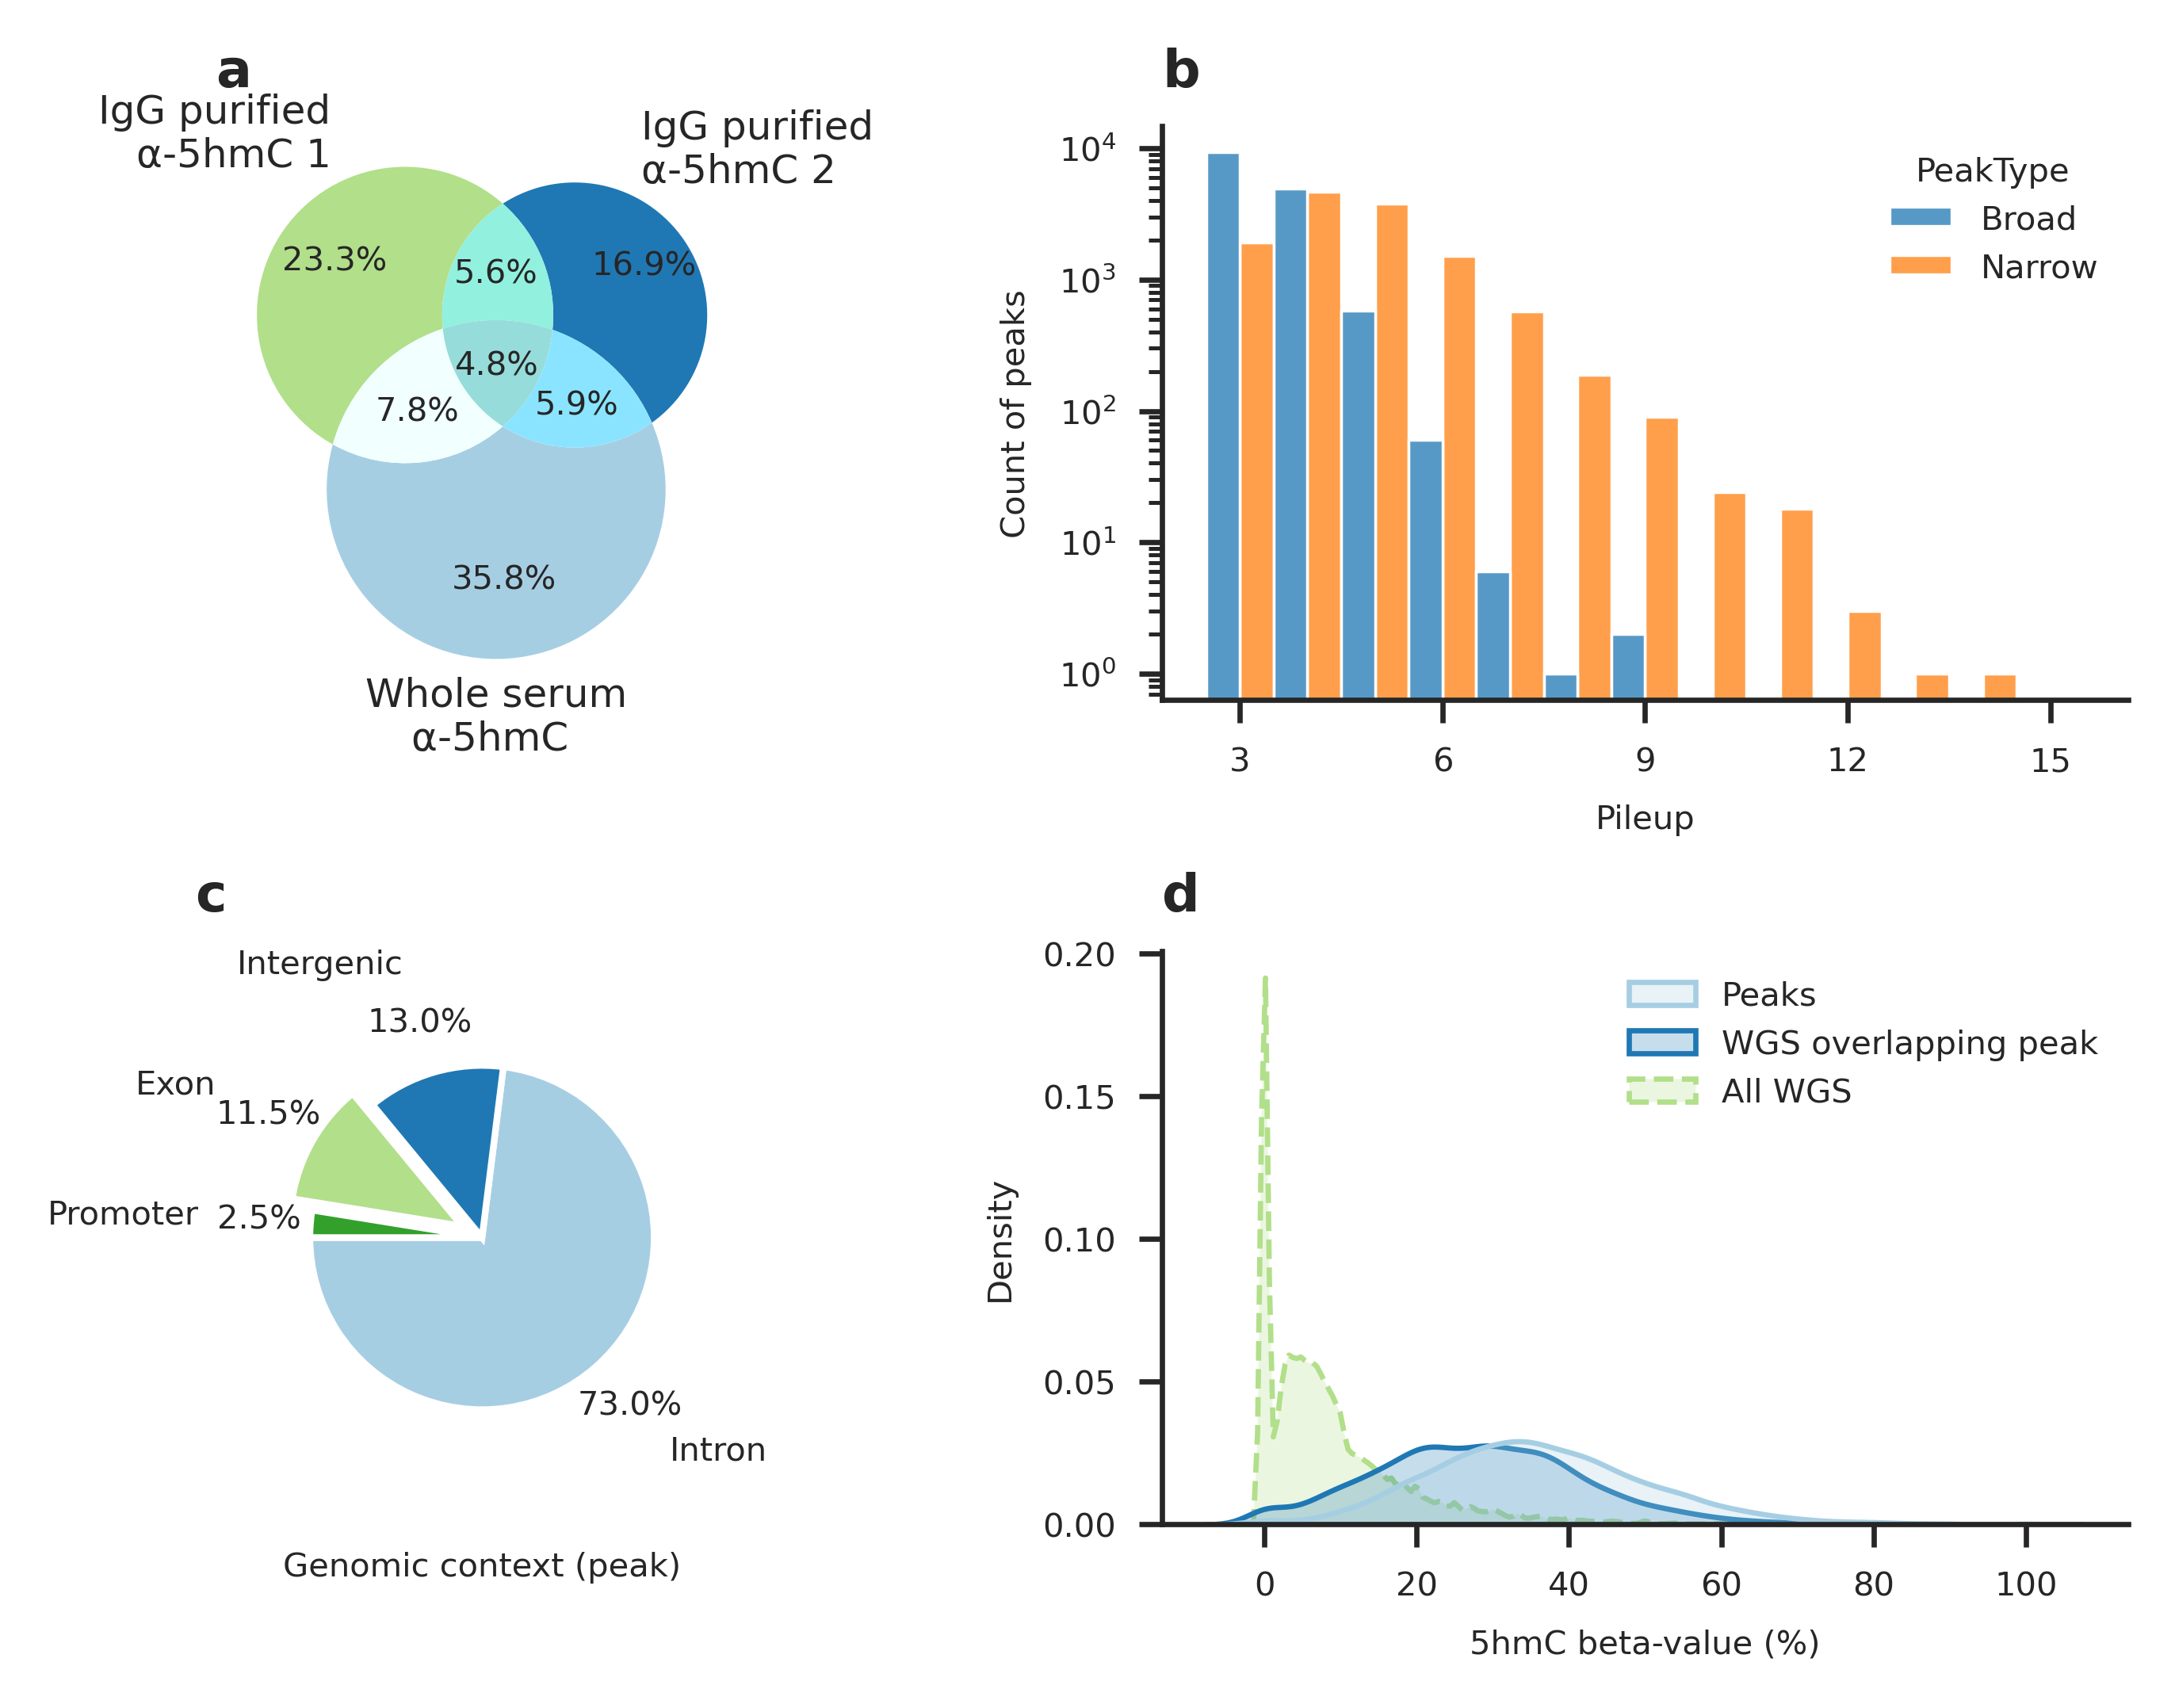

In [146]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib.patches import Patch
from PIL import Image
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 90/25.4), dpi=600)
gs = GridSpec(2, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Panel 1 # 

VennDiagrammer3Ways(pilot_pr, rep1_pr, rep2_pr, ax=ax1)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 # 

sns.histplot(all_peaks, x="pileup",
             discrete=True, binrange=(3, 15),
             hue="PeakType", multiple="dodge",
             log_scale=(False, True),
             ax=ax2)

ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.set_xlabel("Pileup")
ax2.set_ylabel("Count of peaks")
ax2.set_xticks(range(3, 18, 3))

sns.move_legend(ax2, "upper right", frameon=False)
# Panel 3 # 
ax3.pie(pie_values, labels=pie_labels, startangle=180, explode=(0, 0, .1, 0), radius=0.75, 
        colors=sns.color_palette("Paired", 4), autopct="%1.1f%%",
        pctdistance=1.3, labeldistance=1.65)

ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax3.set_xlabel("Genomic context (peak)")

# Panel 4 # 

kde = sns.kdeplot(all_kde, x="percentMeth_5hmC_Nanopore", 
            hue="data_type", hue_order=["Peaks", "WGS overlapping peak", "All WGS"],
            palette="Paired", fill=True,
            lw=.8,
            legend=True, common_norm=False,
            ax=ax4)

kde.collections[0].set_linestyle("--")
kde.legend_.legend_handles[2].set_ls("--")

ax4.set_xlabel("5hmC beta-value (%)")
ax4.set_ylabel("Density")

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
sns.move_legend(ax4, "upper right", frameon=False, title=None)

# Figure # 

sns.despine()
sns.despine(ax=ax5, bottom=True, left=True)

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP_extras.png", dpi=600)


## Broad vs. narrow peaks

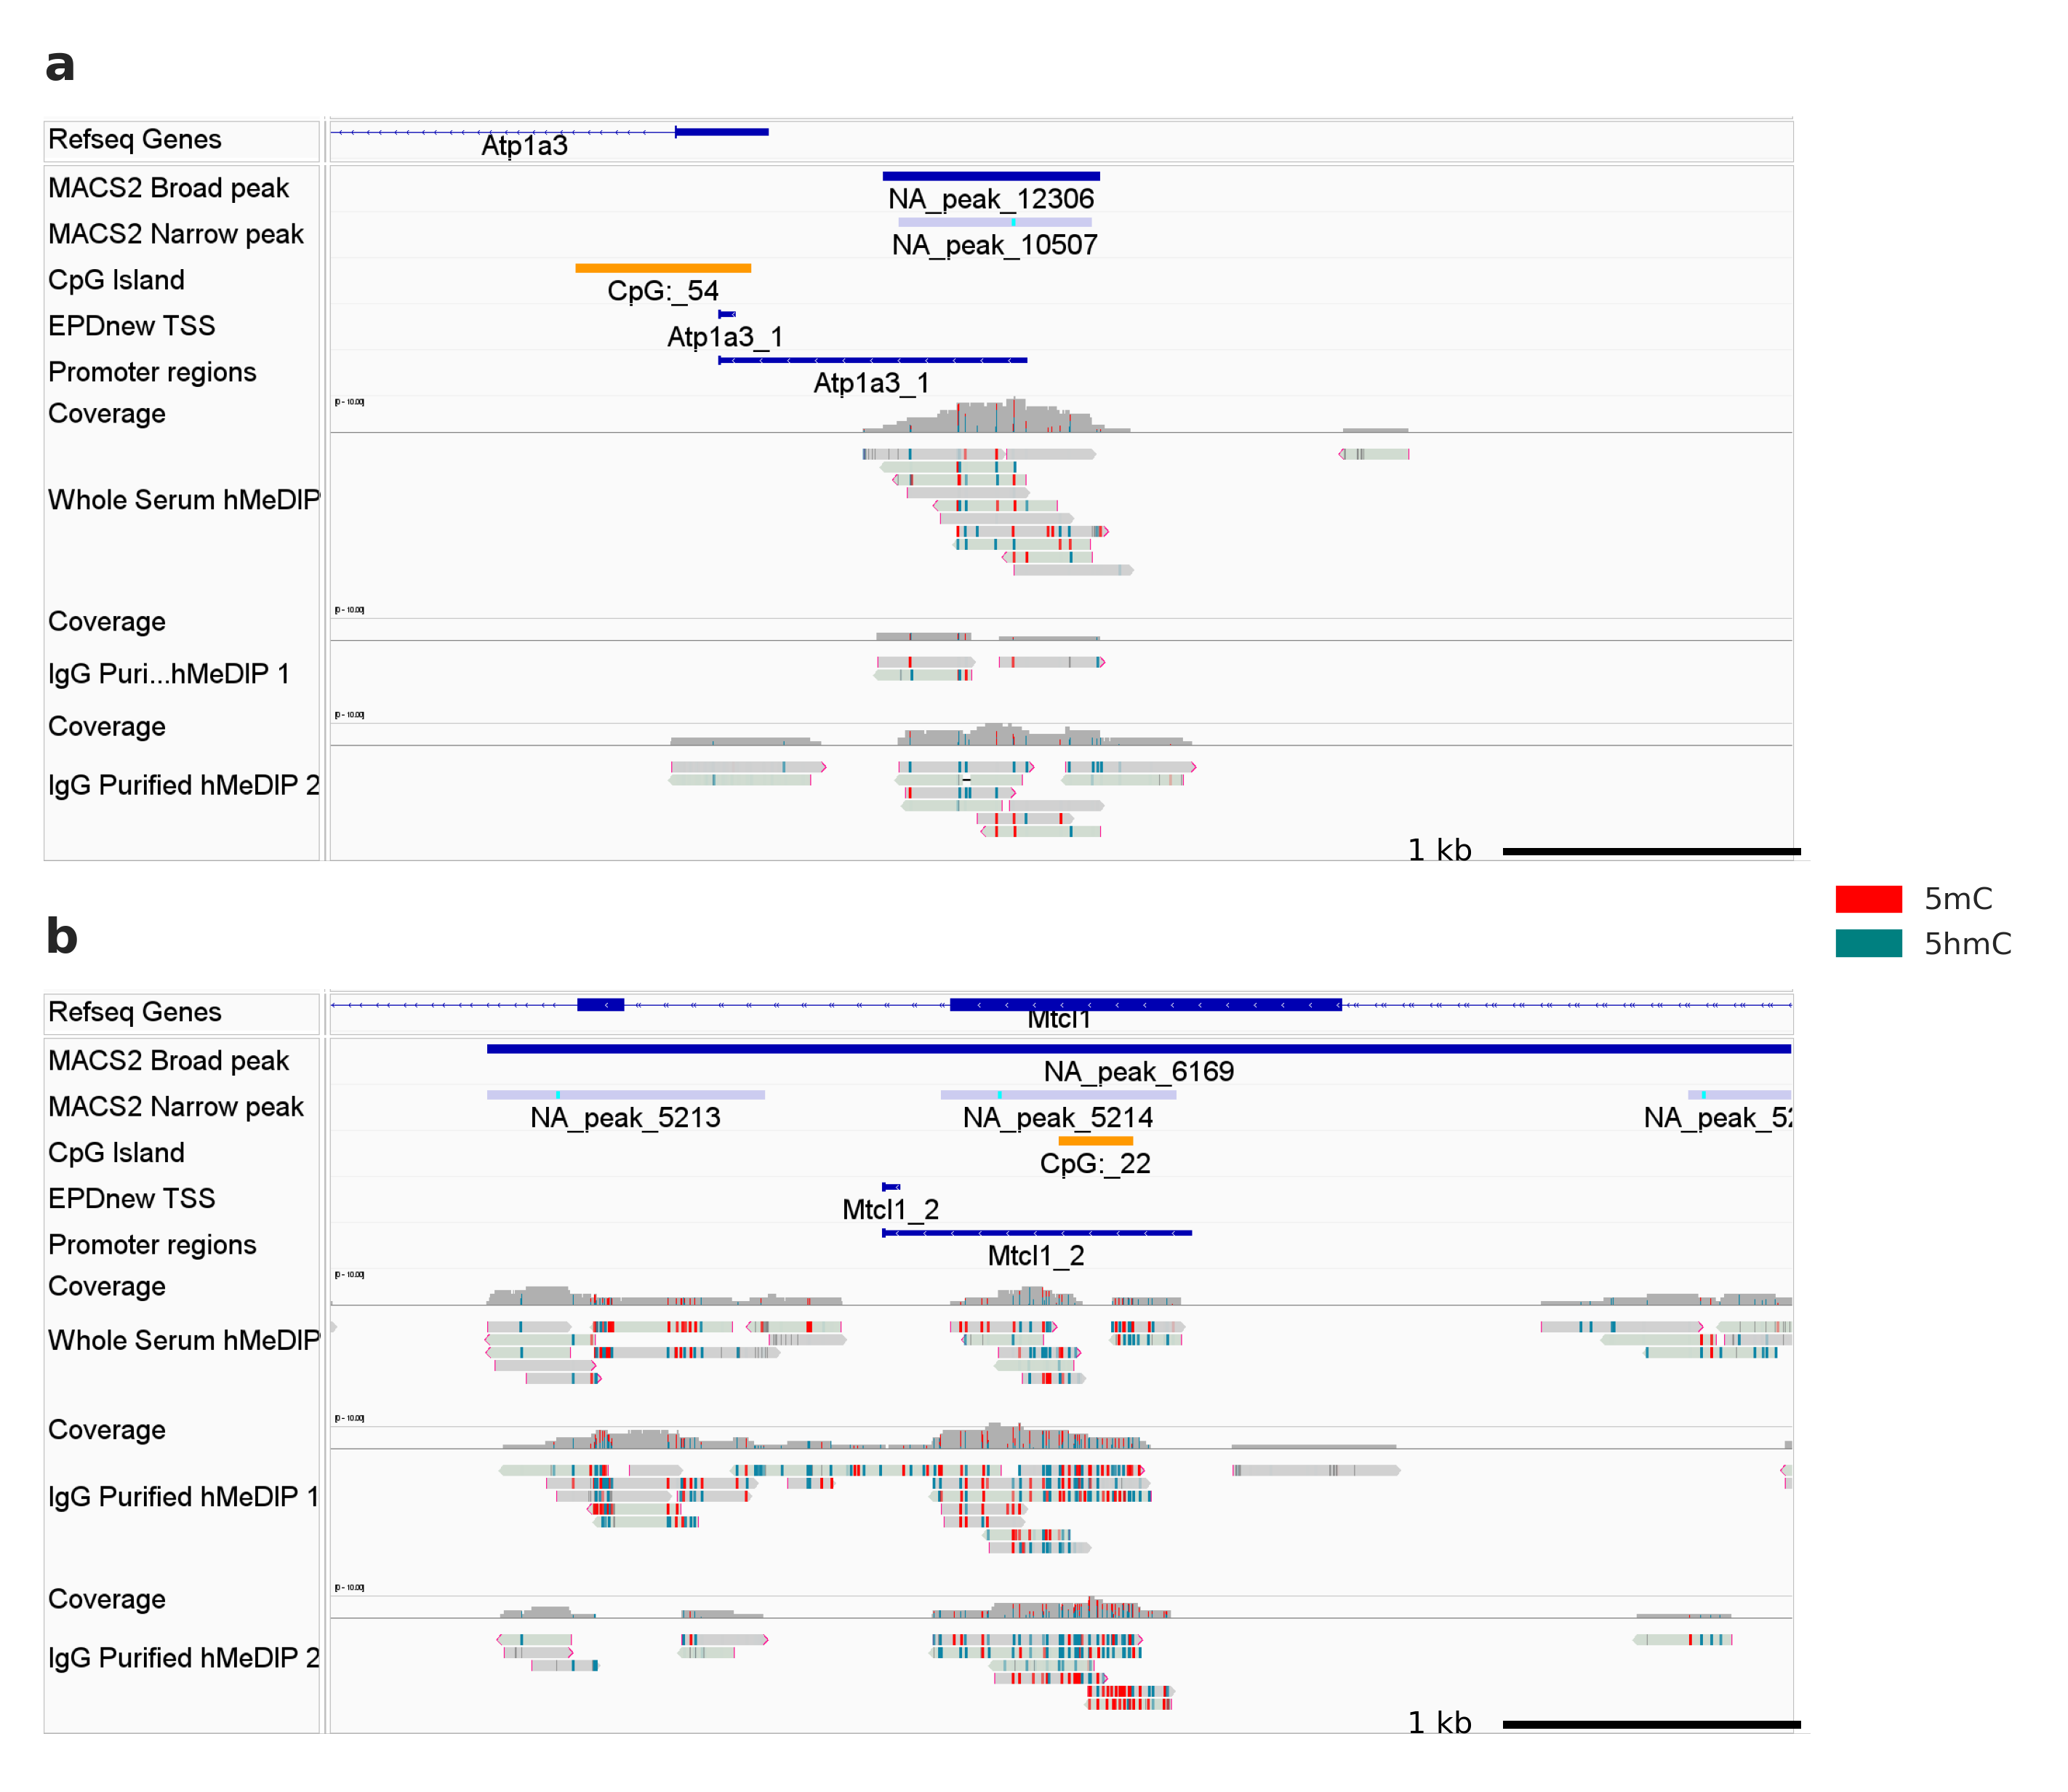

In [151]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib_scalebar
import matplotlib as mpl
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image

fig = plt.figure(figsize=(120/25.4, 100/25.4), dpi=600)
gs = GridSpec(2, 1, fig)

sns.set_style("ticks")
mpl.rc('font', size=5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])
# ax3 = fig.add_subplot(gs[2, :])

# Panel 1 #
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
im1 = Image.open("data_tables/hmedip/rep_img_igv/narrow_peak_Atp1a3_mod.png")

w1, h1 = im1.size
imc = im1.crop((0, 125, w1, 950))

l1_elements = [Patch(facecolor='red', edgecolor='red',
                         label='5mC'),
              Patch(facecolor='teal', edgecolor='teal',
                         label='5hmC')] 

dim = matplotlib_scalebar.dimension._Dimension("bp")
dim.add_units("kb", 1000)

ax1.imshow(imc)
scalebar = ScaleBar(5000/(w1-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
ax1.add_artist(scalebar)

ax1.grid(False)

# ax1.axhline(700, .17, 0.98, lw=0.8, c="k")

# Panel 2 # 

im2 = Image.open("data_tables/hmedip/rep_img_igv/peak_Mtcl1_mod.png")
w2, h2 = im2.size
imc2 = im2.crop((0, 125, w2, 950))

ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

ax2.imshow(imc2)
scalebar2 = ScaleBar(5000/(w2-300), units="bp", dimension=dim, location="lower right", frameon=False, scale_loc="left")
ax2.add_artist(scalebar2)

# Figure # 

for ax in [ax1, ax2]:
    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

plt.figlegend(handles=l1_elements, loc="center right", alignment="left", bbox_to_anchor=(.99, 0.48), frameon=False)

# engine = fig.get_layout_engine()
# engine.set(rect=(-.05, 0, 1, .98))

sns.despine(left=True, bottom=True)
fig.subplots_adjust(top = .95, bottom = 0, right = .9, left = 0, 
            hspace = 0.15, wspace = 0)

fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP_igv.png", dpi=600, pad_inches=0)

Note: First image from chr7:24,704,000-24,709,000.
Second image from chr17:66,684,000-66,689,000.